In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.neighbors import KNeighborsClassifier

#json
import json

<h3>Functions</h3>

In [2]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [3]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [4]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [5]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [6]:
def draw_roc_curve(Y_test, Y_pred, diz, k):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    diz[k] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc": roc_auc}
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    plt.show()

<h3>Numerical encoding</h3>

In [7]:
df = pd.read_csv("Numerical_Encoding_Train_HR_Employee_Attrition.csv")

In [8]:
df

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,2,9,4,2,0,3,3,11,...,17,3,0,2,2,8,7,156.613636,0.387172,2.6
1,36,0,2,1,1,2,0,3,5,8,...,14,3,1,3,3,1,8,157.942308,0.411421,2.8
2,25,0,3,16,3,3,0,3,2,5,...,25,3,1,4,3,1,5,448.055556,0.704402,3.2
3,33,0,2,5,4,2,0,3,1,4,...,14,2,0,1,3,3,7,271.907692,0.841632,2.4
4,31,0,2,9,2,3,1,3,1,3,...,12,3,0,2,3,10,2,106.373333,0.207947,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,38,1,2,12,3,3,1,4,1,2,...,15,4,0,2,3,10,0,282.466667,0.789828,3.2
879,37,0,2,16,2,4,1,4,1,3,...,13,2,2,3,2,17,0,76.291667,0.711223,3.2
880,33,1,1,6,4,2,1,1,2,5,...,18,2,0,2,2,11,7,272.881579,0.751820,2.0
881,33,0,2,4,1,3,0,2,2,5,...,12,1,0,2,4,3,2,208.666667,0.862289,2.2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       883 non-null    int64  
 1   Attrition                 883 non-null    int64  
 2   BusinessTravel            883 non-null    int64  
 3   DistanceFromHome          883 non-null    int64  
 4   Education                 883 non-null    int64  
 5   EnvironmentSatisfaction   883 non-null    int64  
 6   Gender                    883 non-null    int64  
 7   JobInvolvement            883 non-null    int64  
 8   JobLevel                  883 non-null    int64  
 9   JobRole                   883 non-null    int64  
 10  JobSatisfaction           883 non-null    int64  
 11  MonthlyIncome             883 non-null    int64  
 12  NumCompaniesWorked        883 non-null    int64  
 13  OverTime                  883 non-null    int64  
 14  PercentSal

In [10]:
df.describe()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,2.062288,9.201586,2.886750,2.684032,0.388448,2.750849,1.919592,4.371461,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245826,0.463811,2.724575
std,8.266129,0.378698,0.512402,8.241818,1.008285,1.092567,0.487674,0.729354,1.007506,2.290214,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196628,0.320030,0.438169
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.043478,0.000000,1.200000
25%,30.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,3.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630208,0.129730,2.400000
50%,35.000000,0.000000,2.000000,7.000000,3.000000,3.000000,0.000000,3.000000,2.000000,4.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.279070,0.528359,2.800000
75%,42.000000,0.000000,2.000000,14.000000,4.000000,4.000000,1.000000,3.000000,2.000000,5.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.906250,0.762560,3.000000
max,60.000000,1.000000,3.000000,29.000000,5.000000,4.000000,1.000000,4.000000,5.000000,11.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.976744,0.951396,4.000000


<h3>Discretization</h3>

Continuous features to discretize:
- <b>Age</b>
- <b>DistanceFromHome</b>
- <b>YearsAtCompany</b>
- <b>YearsInCurrentRole</b>
- <b>NumCompaniesWorked</b>
- <b>MonthlyIncome</b>
- <b>MonthlyHours</b>
- <b>PercentSalaryHike</b>

In [11]:
columns_to_discretize = ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike']

In [12]:
df.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,2,9,4,2,0,3,3,11,...,17,3,0,2,2,8,7,156.613636,0.387172,2.6
1,36,0,2,1,1,2,0,3,5,8,...,14,3,1,3,3,1,8,157.942308,0.411421,2.8
2,25,0,3,16,3,3,0,3,2,5,...,25,3,1,4,3,1,5,448.055556,0.704402,3.2
3,33,0,2,5,4,2,0,3,1,4,...,14,2,0,1,3,3,7,271.907692,0.841632,2.4
4,31,0,2,9,2,3,1,3,1,3,...,12,3,0,2,3,10,2,106.373333,0.207947,3.2


In [13]:
for column in columns_to_discretize:
    if column in df:
        df[column] = pd.qcut(df[column], q=4, duplicates='drop', labels=False)

In [14]:
df.head()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,3,0,2,2,4,2,0,3,3,11,...,2,3,0,2,2,2,2,1,0.387172,2.6
1,2,0,2,0,1,2,0,3,5,8,...,1,3,1,3,3,0,3,1,0.411421,2.8
2,0,0,3,3,3,3,0,3,2,5,...,3,3,1,4,3,0,2,3,0.704402,3.2
3,1,0,2,1,4,2,0,3,1,4,...,1,2,0,1,3,0,2,2,0.841632,2.4
4,1,0,2,2,2,3,1,3,1,3,...,0,3,0,2,3,3,0,0,0.207947,3.2


<h3>Divide into features and target</h3>

In [15]:
attributes = [col for col in df.columns if col != 'Attrition']

X = df[attributes].values
y = df['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

In [16]:
scaler_dict = dict()

<h4>MinMaxScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6024050839467673
Best parameters: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

Best k ('n_neighbors'): 6

Plots of the metrics used by the grid search


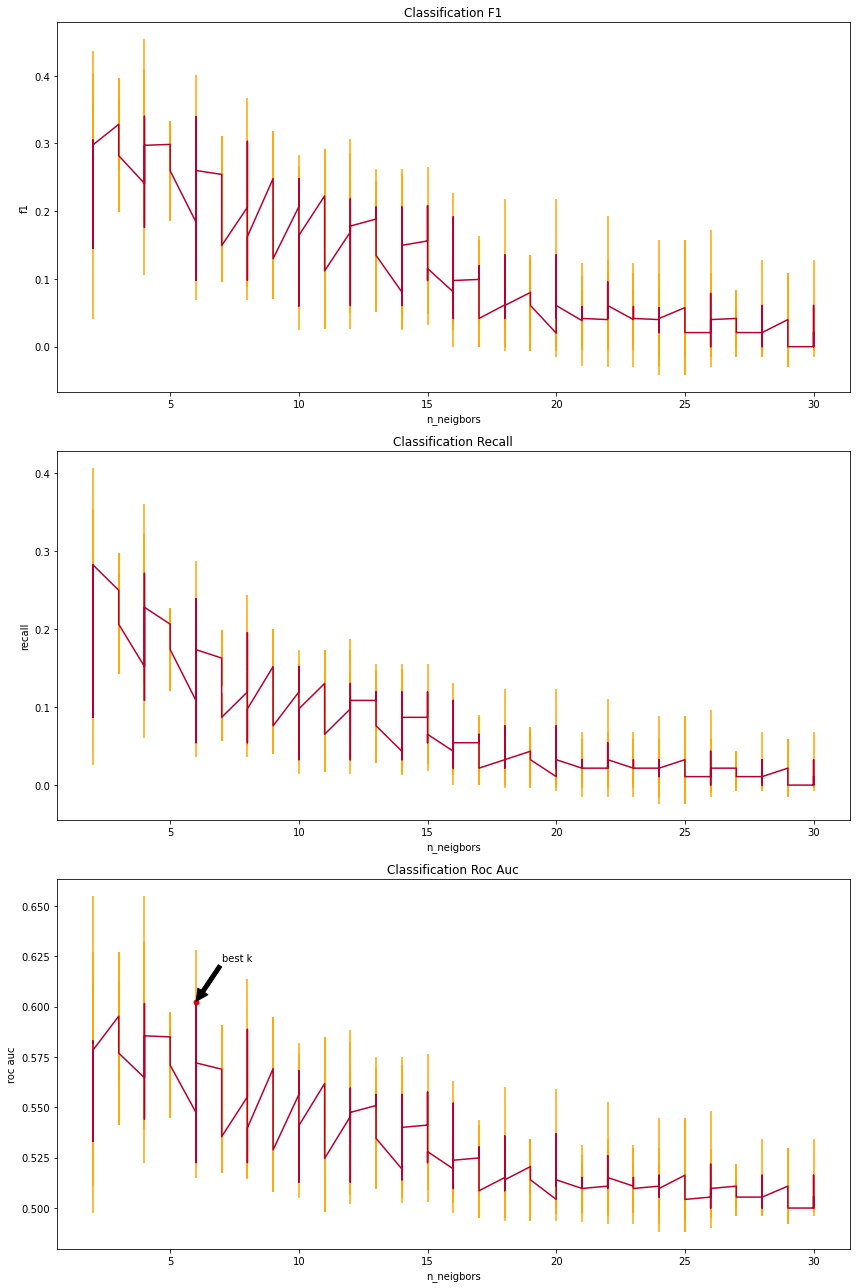



Permutation importances of the training set

OverTime                                           0.000535
DistanceFromHome                                   0.000030
RelationshipSatisfaction                           0.000027
YearsAtCompany                                     0.000027
JobSatisfaction                                    0.000015
NumCompaniesWorked                                 0.000002
PercentSalaryHike                                  0.000002
StockOptionLevel                                   0.000002
Age                                                0.000000
BusinessTravel                                     0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.

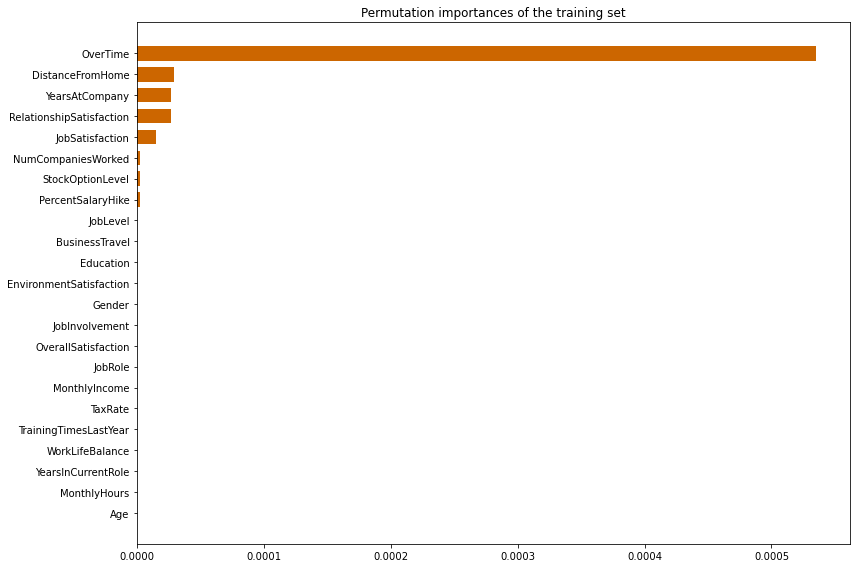



Predictions

Permutation importances of the test set

OverTime                                           0.027763
YearsInCurrentRole                                 0.011873
JobLevel                                           0.009534
YearsAtCompany                                     0.009109
OverallSatisfaction                                0.005184
StockOptionLevel                                   0.001894
TrainingTimesLastYear                              0.001337
EnvironmentSatisfaction                            0.000389
Education                                          -0.001986
JobInvolvement                                     -0.004946
JobRole                                            -0.007444
RelationshipSatisfaction                           -0.010300
Age                                                -0.010840
NumCompaniesWorked                                 -0.013923
BusinessTravel                                     -0.015837
JobSatisfaction                      

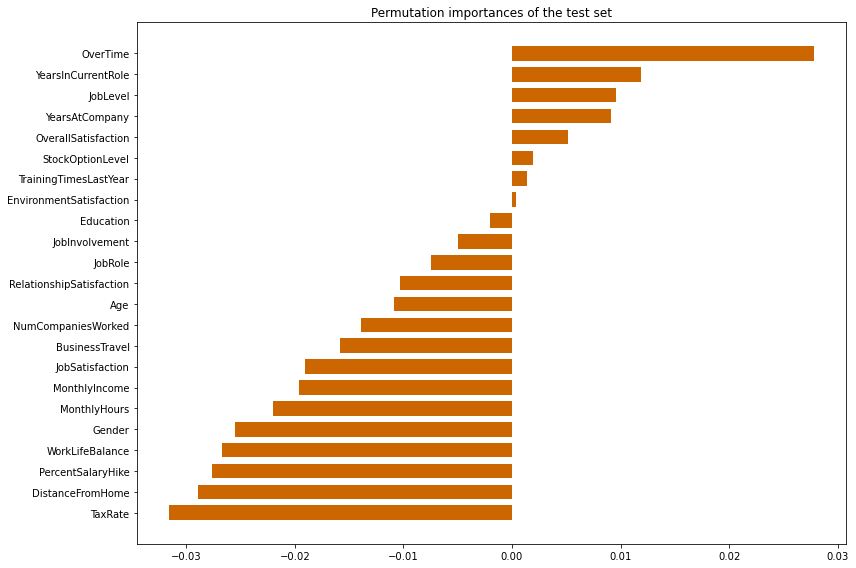



Confusion matrix


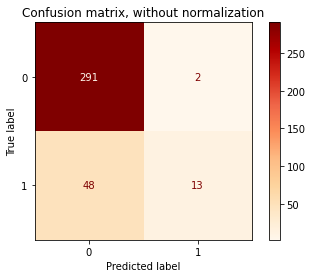

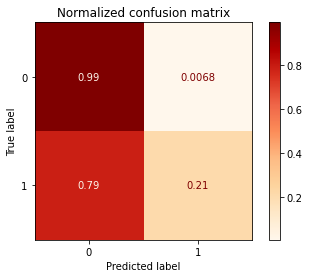


Classification report
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       293
           1       0.87      0.21      0.34        61

    accuracy                           0.86       354
   macro avg       0.86      0.60      0.63       354
weighted avg       0.86      0.86      0.82       354


Metrics

Accuracy 0.8587570621468926
F1-score [0.92088608 0.34210526]
Precision [0.85840708 0.86666667]
Recall [0.99317406 0.21311475]
Roc_auc 0.6031444077659038


Roc curve



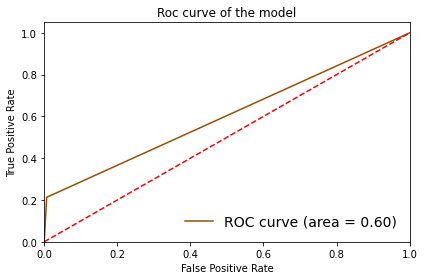


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6025615175006169
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


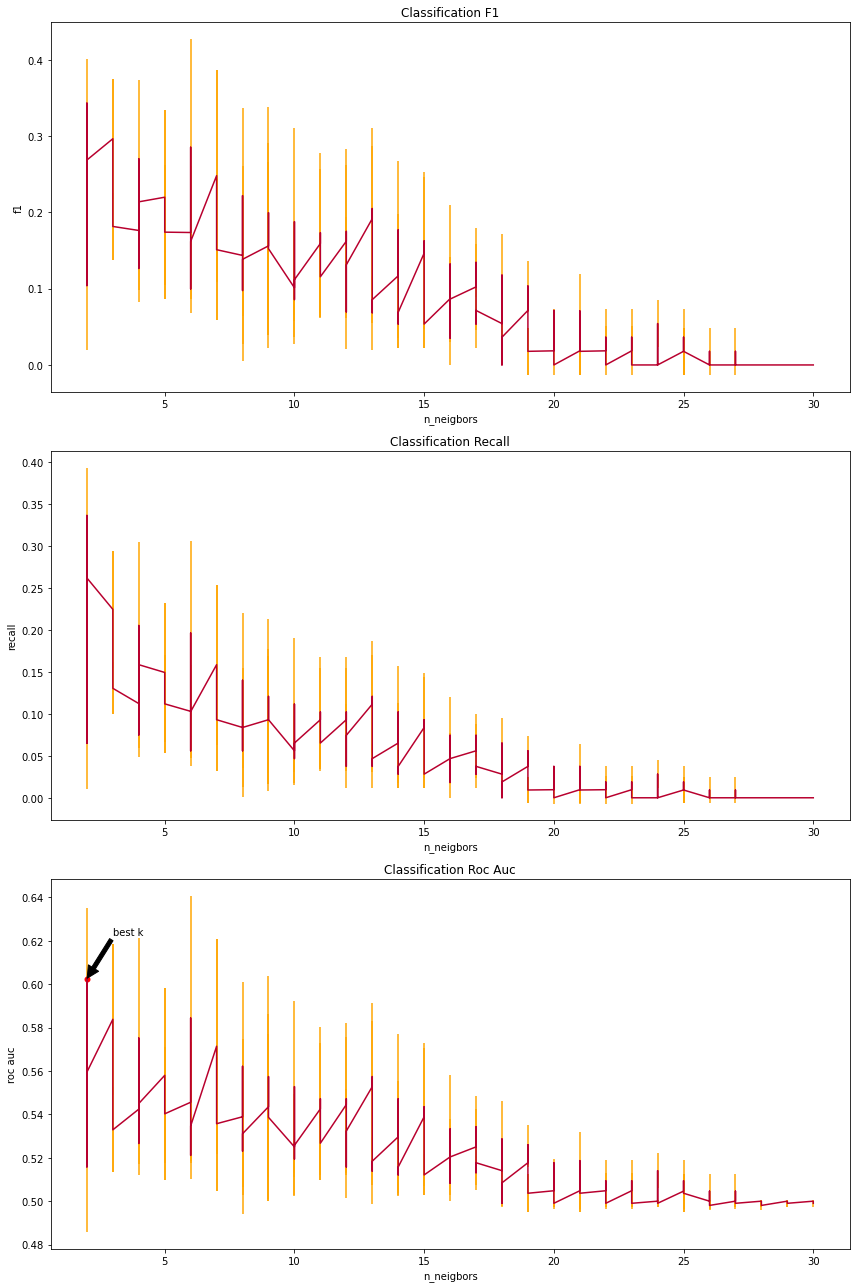



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

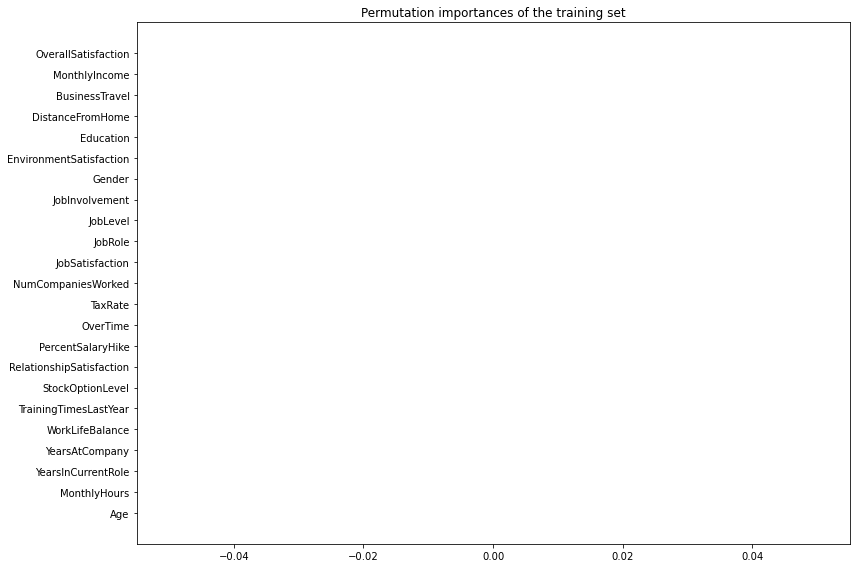



Predictions

Permutation importances of the test set

EnvironmentSatisfaction                            0.041577
StockOptionLevel                                   0.036018
RelationshipSatisfaction                           0.033889
YearsInCurrentRole                                 0.032236
OverTime                                           0.030360
NumCompaniesWorked                                 0.024806
PercentSalaryHike                                  0.021585
OverallSatisfaction                                0.019119
JobInvolvement                                     0.019029
WorkLifeBalance                                    0.017833
MonthlyIncome                                      0.014205
MonthlyHours                                       0.011331
JobSatisfaction                                    0.010204
JobLevel                                           0.008304
Age                                                0.007514
YearsAtCompany                              

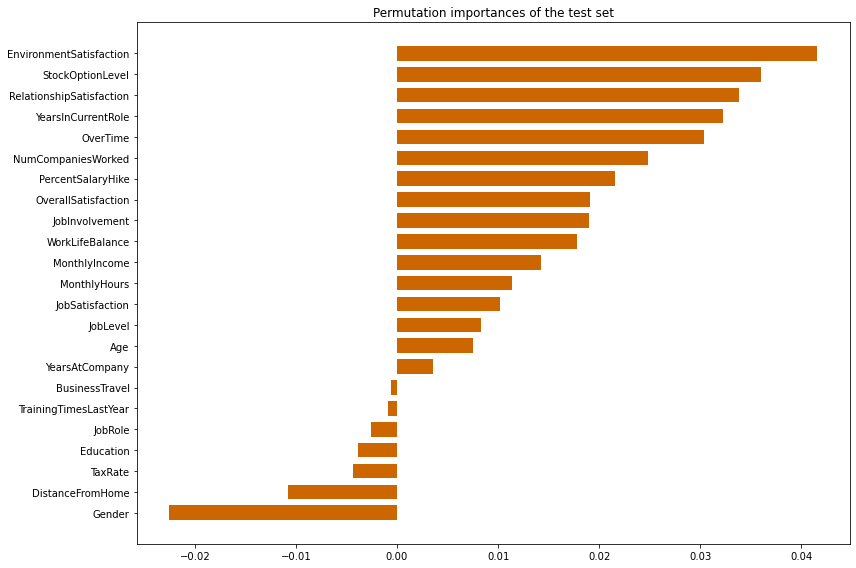



Confusion matrix


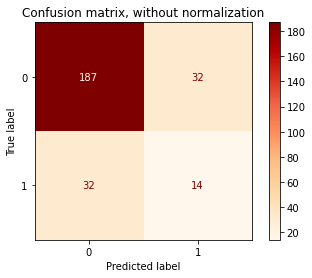

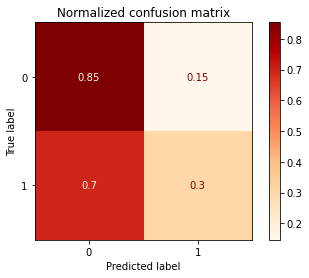


Classification report
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       219
           1       0.30      0.30      0.30        46

    accuracy                           0.76       265
   macro avg       0.58      0.58      0.58       265
weighted avg       0.76      0.76      0.76       265


Metrics

Accuracy 0.7584905660377359
F1-score [0.85388128 0.30434783]
Precision [0.85388128 0.30434783]
Recall [0.85388128 0.30434783]
Roc_auc 0.5791145523128847


Roc curve



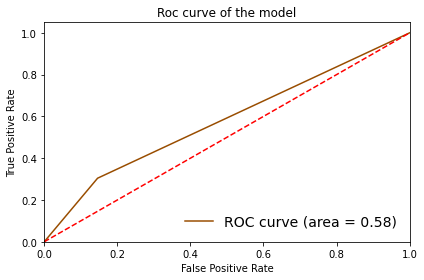


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6310539107379585
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


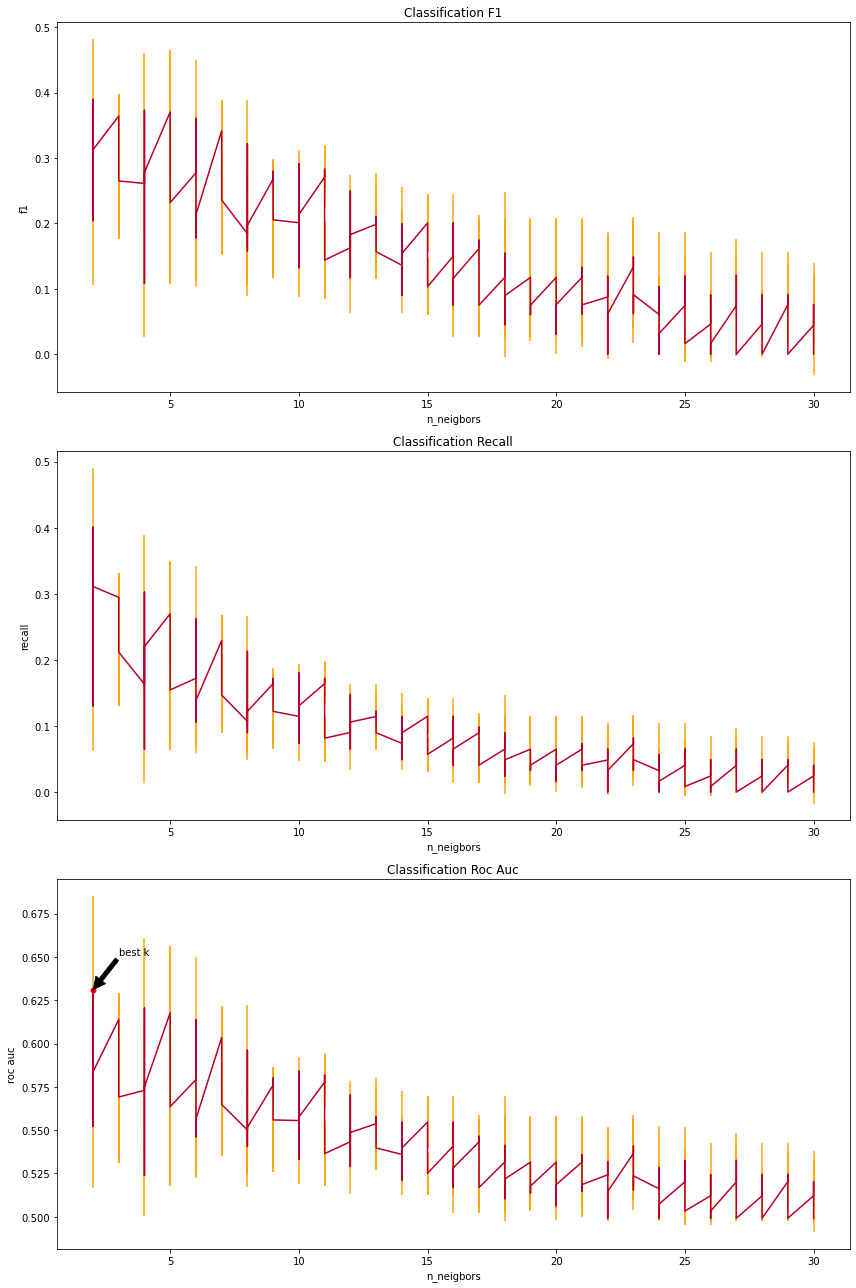



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

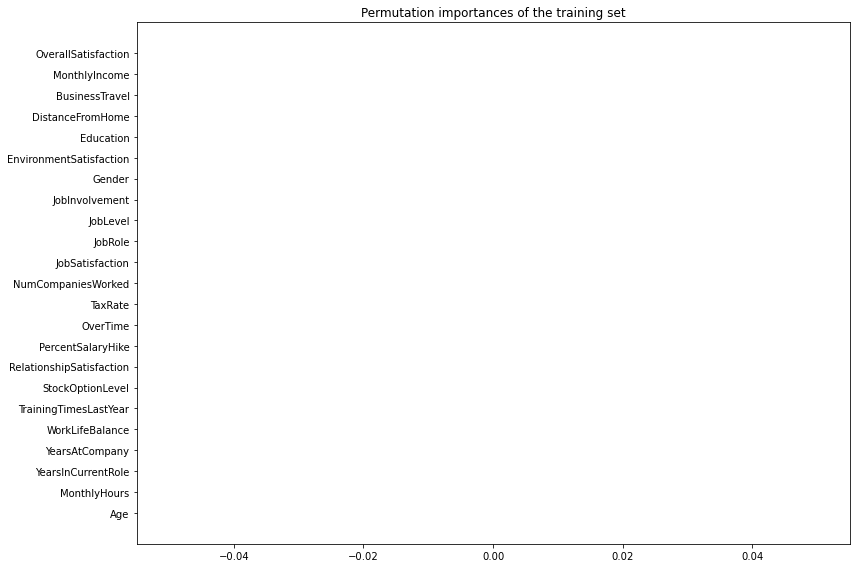



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.060373
NumCompaniesWorked                                 0.043173
EnvironmentSatisfaction                            0.038091
JobInvolvement                                     0.034954
MonthlyIncome                                      0.034788
Age                                                0.032346
YearsInCurrentRole                                 0.031927
OverallSatisfaction                                0.026734
PercentSalaryHike                                  0.022448
JobSatisfaction                                    0.019200
Gender                                             0.017819
TaxRate                                            0.017355
RelationshipSatisfaction                           0.017333
WorkLifeBalance                                    0.016715
OverTime                                           0.014527
JobLevel                                    

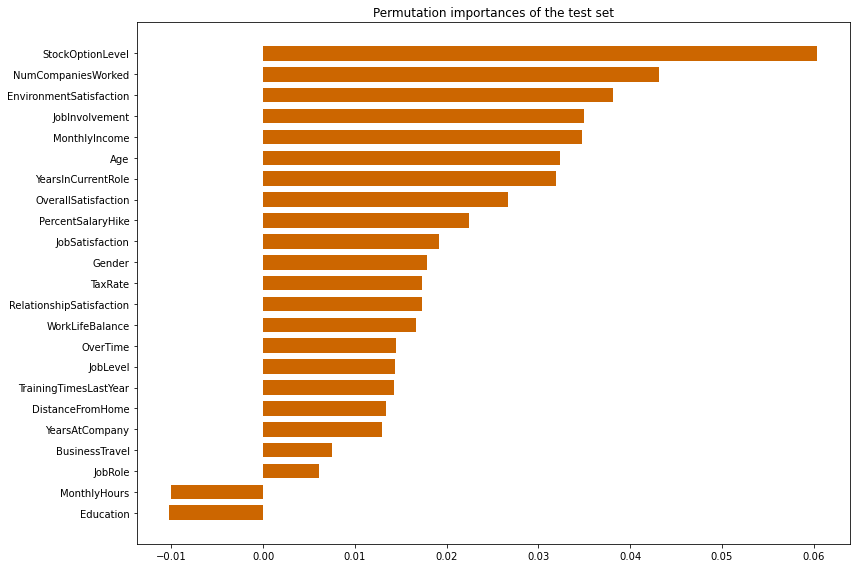



Confusion matrix


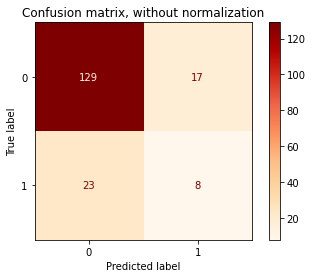

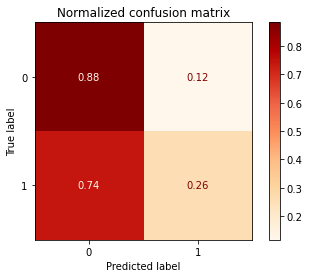


Classification report
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       146
           1       0.32      0.26      0.29        31

    accuracy                           0.77       177
   macro avg       0.58      0.57      0.58       177
weighted avg       0.76      0.77      0.76       177


Metrics

Accuracy 0.7740112994350282
F1-score [0.86577181 0.28571429]
Precision [0.84868421 0.32      ]
Recall [0.88356164 0.25806452]
Roc_auc 0.5708130799823243


Roc curve



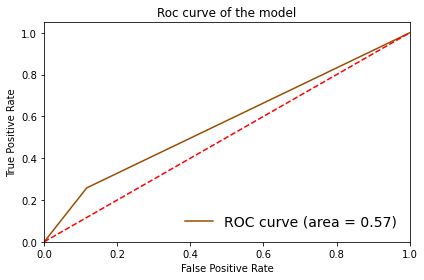


-------------------------------------------------------------------------------------------------------------



In [17]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
min_max_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, min_max_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = min_max_dict

<h4>MaxAbsScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6026543859012945
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


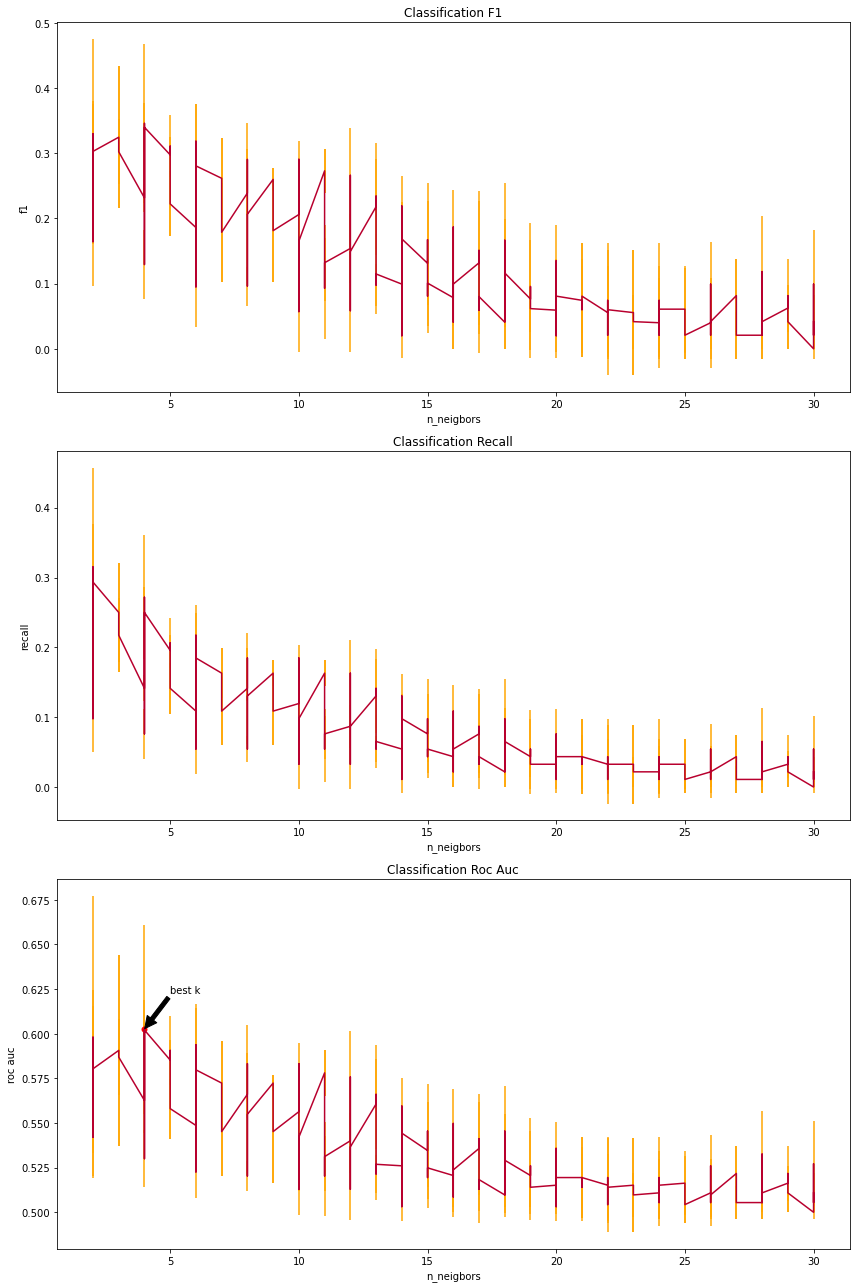



Permutation importances of the training set

StockOptionLevel                                   0.000007
DistanceFromHome                                   0.000002
PercentSalaryHike                                  0.000002
Age                                                0.000000
BusinessTravel                                     0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.

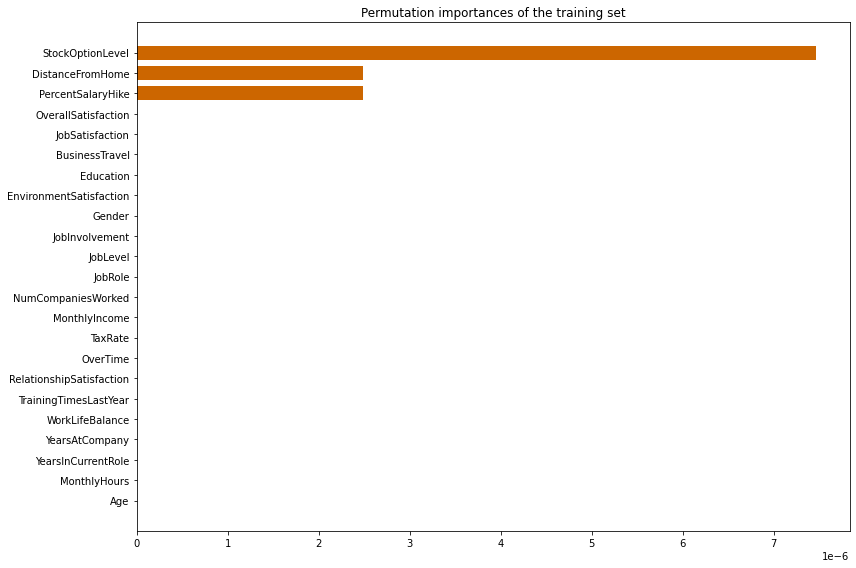



Predictions

Permutation importances of the test set

YearsInCurrentRole                                 0.033828
OverTime                                           0.033732
EnvironmentSatisfaction                            0.025270
YearsAtCompany                                     0.024822
StockOptionLevel                                   0.017462
RelationshipSatisfaction                           0.017003
Age                                                0.015098
JobLevel                                           0.014399
NumCompaniesWorked                                 0.012421
OverallSatisfaction                                0.010852
JobInvolvement                                     0.004700
PercentSalaryHike                                  0.000330
Education                                          -0.002336
MonthlyIncome                                      -0.003466
MonthlyHours                                       -0.007086
Gender                                   

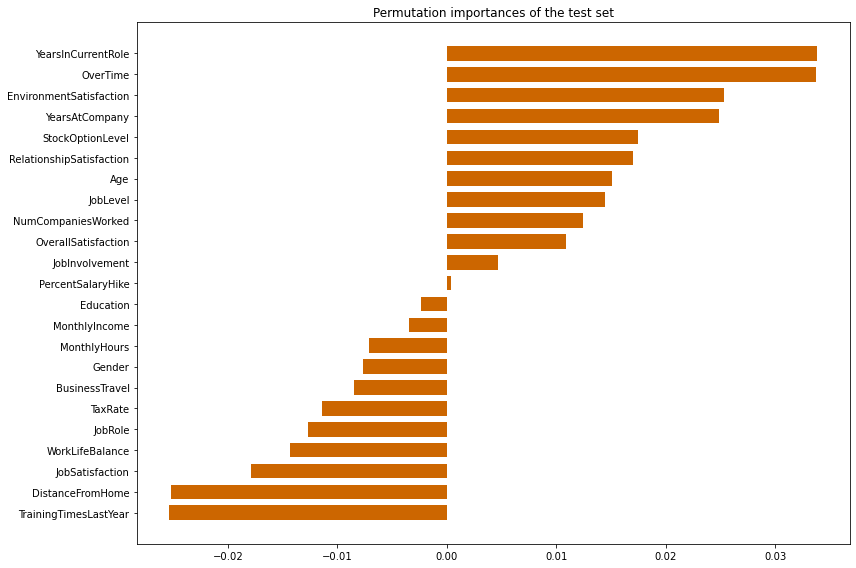



Confusion matrix


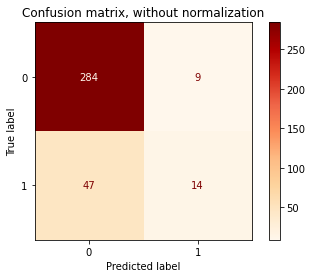

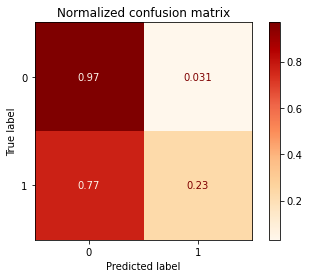


Classification report
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       293
           1       0.61      0.23      0.33        61

    accuracy                           0.84       354
   macro avg       0.73      0.60      0.62       354
weighted avg       0.82      0.84      0.81       354


Metrics

Accuracy 0.8418079096045198
F1-score [0.91025641 0.33333333]
Precision [0.85800604 0.60869565]
Recall [0.96928328 0.2295082 ]
Roc_auc 0.5993957365859117


Roc curve



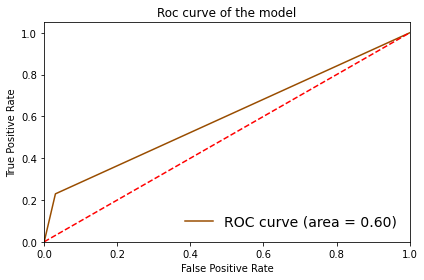


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6241280449418983
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


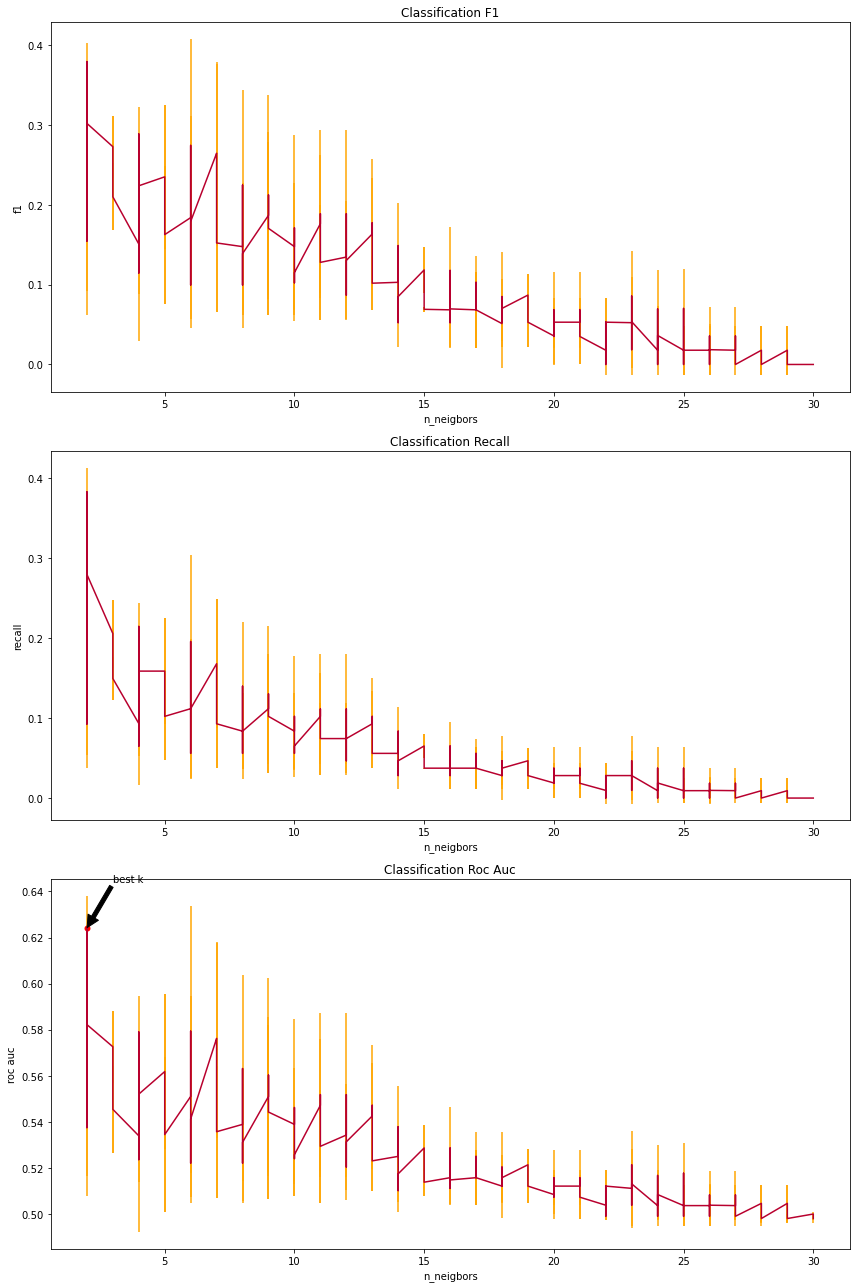



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

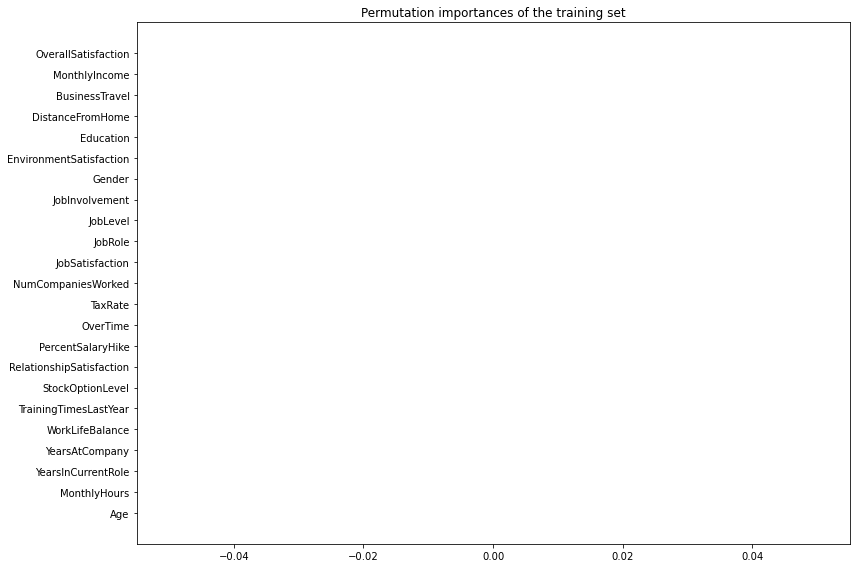



Predictions

Permutation importances of the test set

EnvironmentSatisfaction                            0.034817
JobLevel                                           0.021014
OverTime                                           0.019689
YearsInCurrentRole                                 0.010264
OverallSatisfaction                                0.009778
StockOptionLevel                                   0.007509
NumCompaniesWorked                                 0.006914
RelationshipSatisfaction                           0.006199
JobInvolvement                                     0.005564
YearsAtCompany                                     0.001673
BusinessTravel                                     0.000963
Education                                          -0.000273
Age                                                -0.000586
PercentSalaryHike                                  -0.001697
TrainingTimesLastYear                              -0.004025
WorkLifeBalance                         

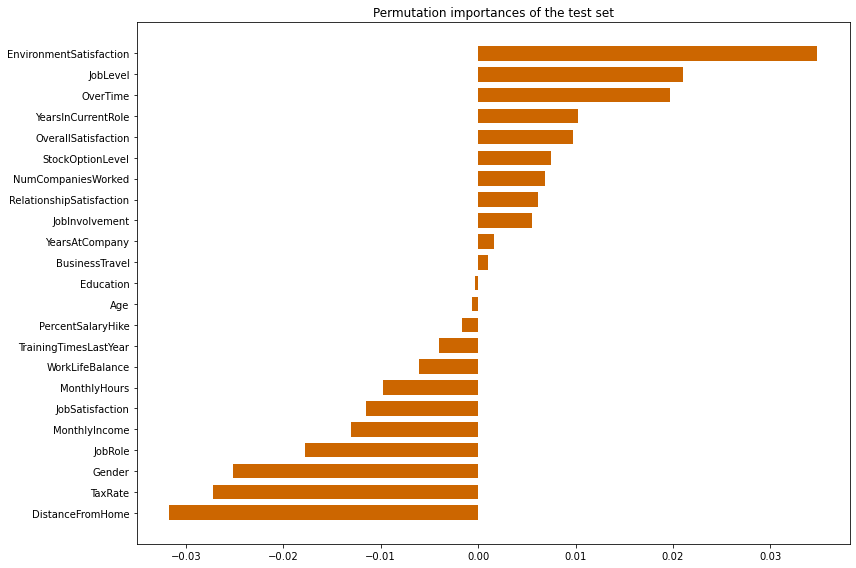



Confusion matrix


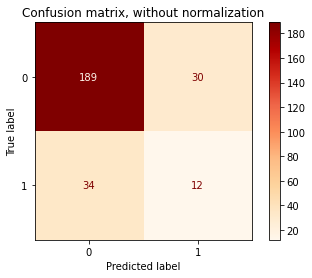

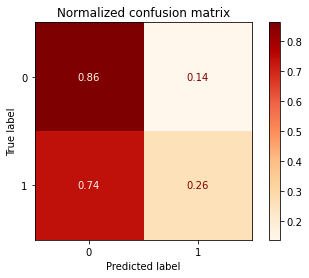


Classification report
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       219
           1       0.29      0.26      0.27        46

    accuracy                           0.76       265
   macro avg       0.57      0.56      0.56       265
weighted avg       0.75      0.76      0.75       265


Metrics

Accuracy 0.7584905660377359
F1-score [0.85520362 0.27272727]
Precision [0.84753363 0.28571429]
Recall [0.8630137  0.26086957]
Roc_auc 0.5619416319237641


Roc curve



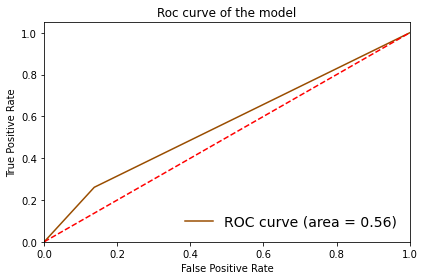


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6254105906613641
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


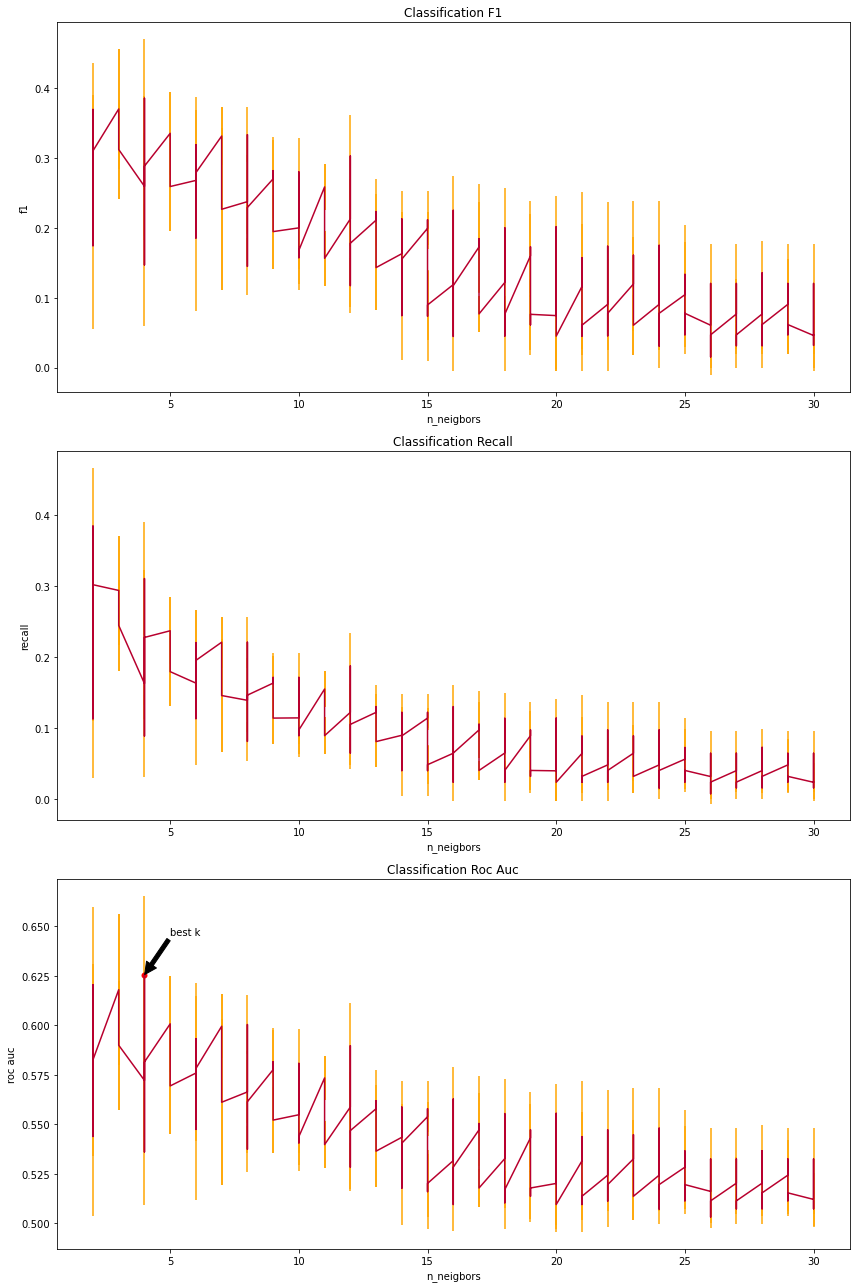



Permutation importances of the training set

OverTime                                           0.000072
YearsAtCompany                                     0.000006
StockOptionLevel                                   0.000004
DistanceFromHome                                   0.000003
NumCompaniesWorked                                 0.000003
Age                                                0.000000
BusinessTravel                                     0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.

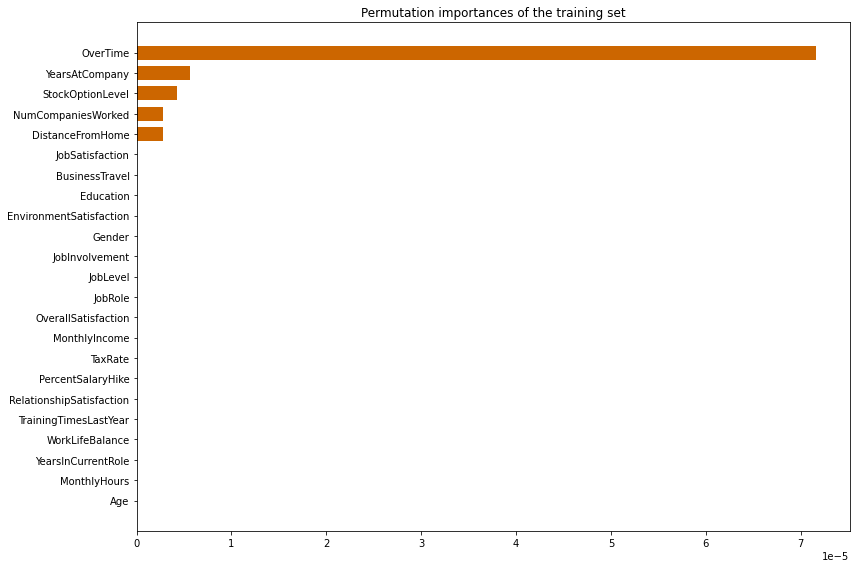



Predictions

Permutation importances of the test set

PercentSalaryHike                                  0.035340
EnvironmentSatisfaction                            0.030192
OverTime                                           0.029518
Age                                                0.026226
OverallSatisfaction                                0.026083
StockOptionLevel                                   0.021620
JobSatisfaction                                    0.021575
JobLevel                                           0.016703
YearsInCurrentRole                                 0.016251
JobInvolvement                                     0.012439
MonthlyIncome                                      0.012163
NumCompaniesWorked                                 0.011986
DistanceFromHome                                   -0.000497
TrainingTimesLastYear                              -0.002066
YearsAtCompany                                     -0.004728
JobRole                                  

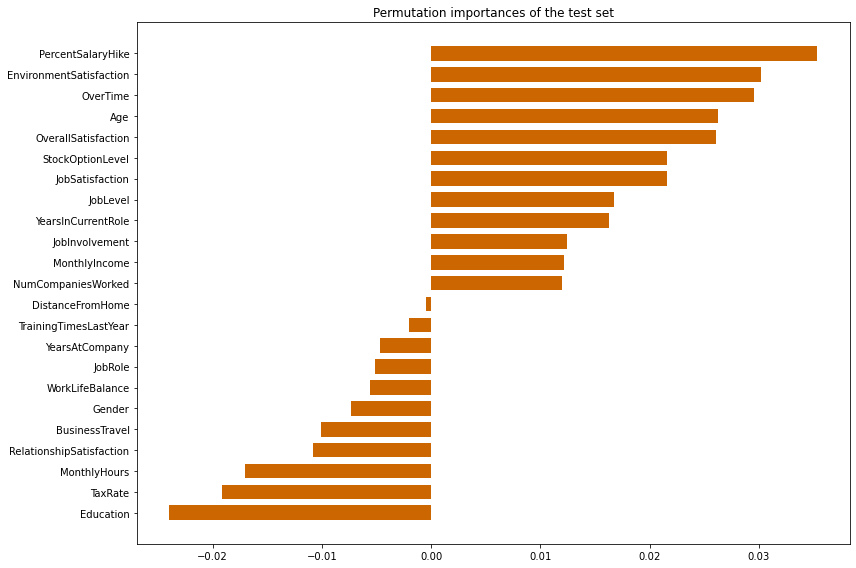



Confusion matrix


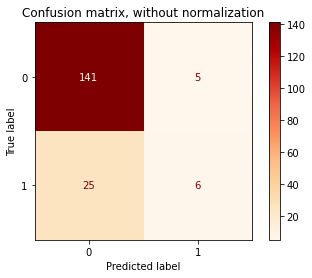

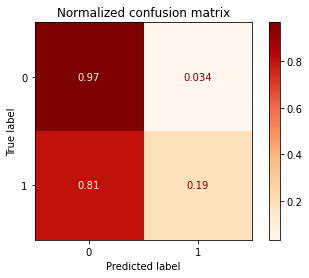


Classification report
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       146
           1       0.55      0.19      0.29        31

    accuracy                           0.83       177
   macro avg       0.70      0.58      0.59       177
weighted avg       0.80      0.83      0.80       177


Metrics

Accuracy 0.8305084745762712
F1-score [0.90384615 0.28571429]
Precision [0.84939759 0.54545455]
Recall [0.96575342 0.19354839]
Roc_auc 0.5796509058771543


Roc curve



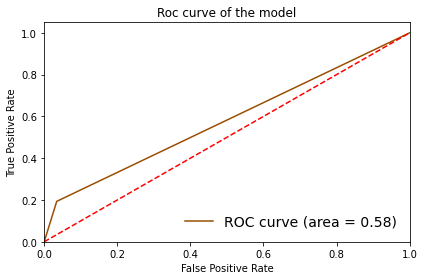


-------------------------------------------------------------------------------------------------------------



In [18]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
max_abs_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MaxAbsScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, max_abs_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = max_abs_dict

<h4>RobustScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6015388729738551
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


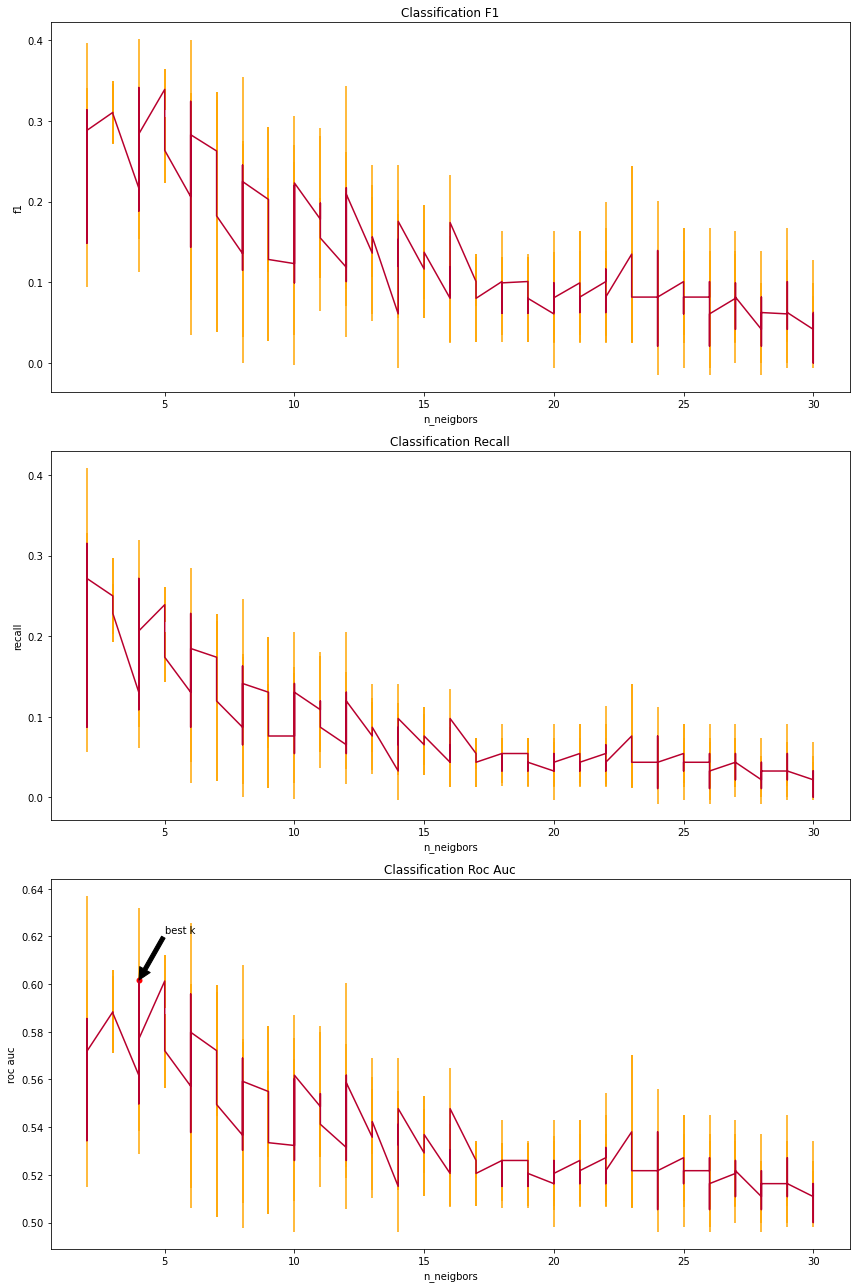



Permutation importances of the training set

StockOptionLevel                                   0.000040
TrainingTimesLastYear                              0.000010
JobLevel                                           0.000005
JobRole                                            0.000002
WorkLifeBalance                                    0.000002
Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.

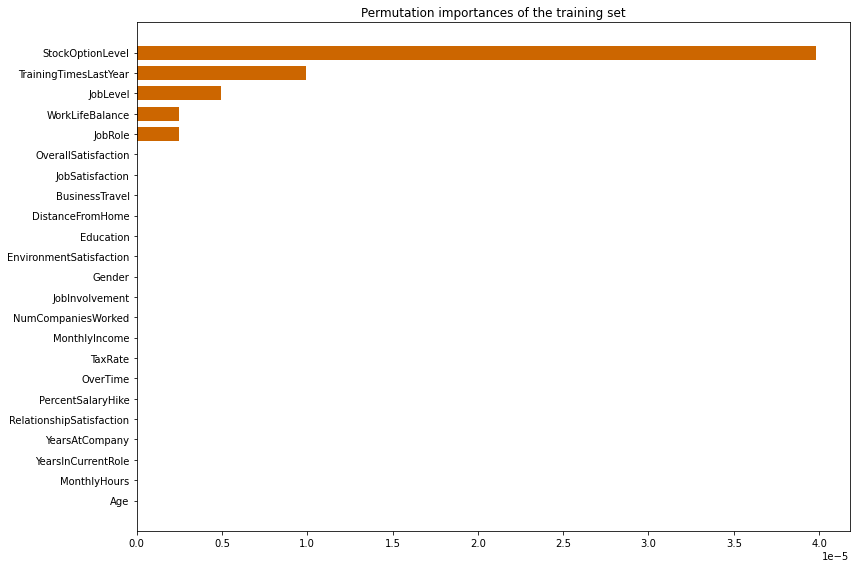



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.035825
WorkLifeBalance                                    0.012477
OverallSatisfaction                                0.011999
YearsInCurrentRole                                 0.009920
OverTime                                           0.006666
YearsAtCompany                                     0.000467
NumCompaniesWorked                                 -0.001502
JobLevel                                           -0.001536
Education                                          -0.004658
EnvironmentSatisfaction                            -0.008339
RelationshipSatisfaction                           -0.010454
JobSatisfaction                                    -0.010840
BusinessTravel                                     -0.012010
MonthlyHours                                       -0.012317
JobRole                                            -0.013297
Gender                             

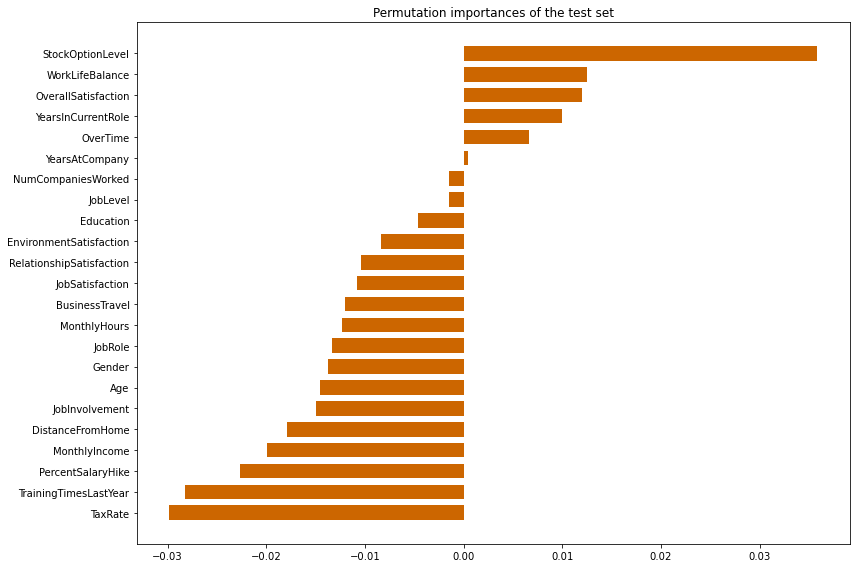



Confusion matrix


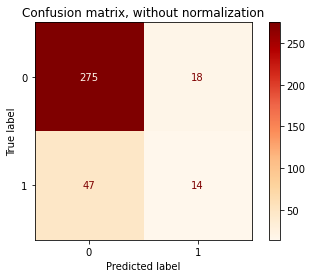

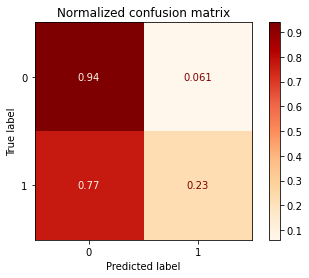


Classification report
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       293
           1       0.44      0.23      0.30        61

    accuracy                           0.82       354
   macro avg       0.65      0.58      0.60       354
weighted avg       0.78      0.82      0.79       354


Metrics

Accuracy 0.8163841807909604
F1-score [0.89430894 0.30107527]
Precision [0.85403727 0.4375    ]
Recall [0.93856655 0.2295082 ]
Roc_auc 0.5840373748111677


Roc curve



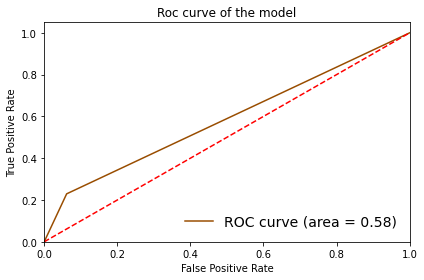


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5809920544787671
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


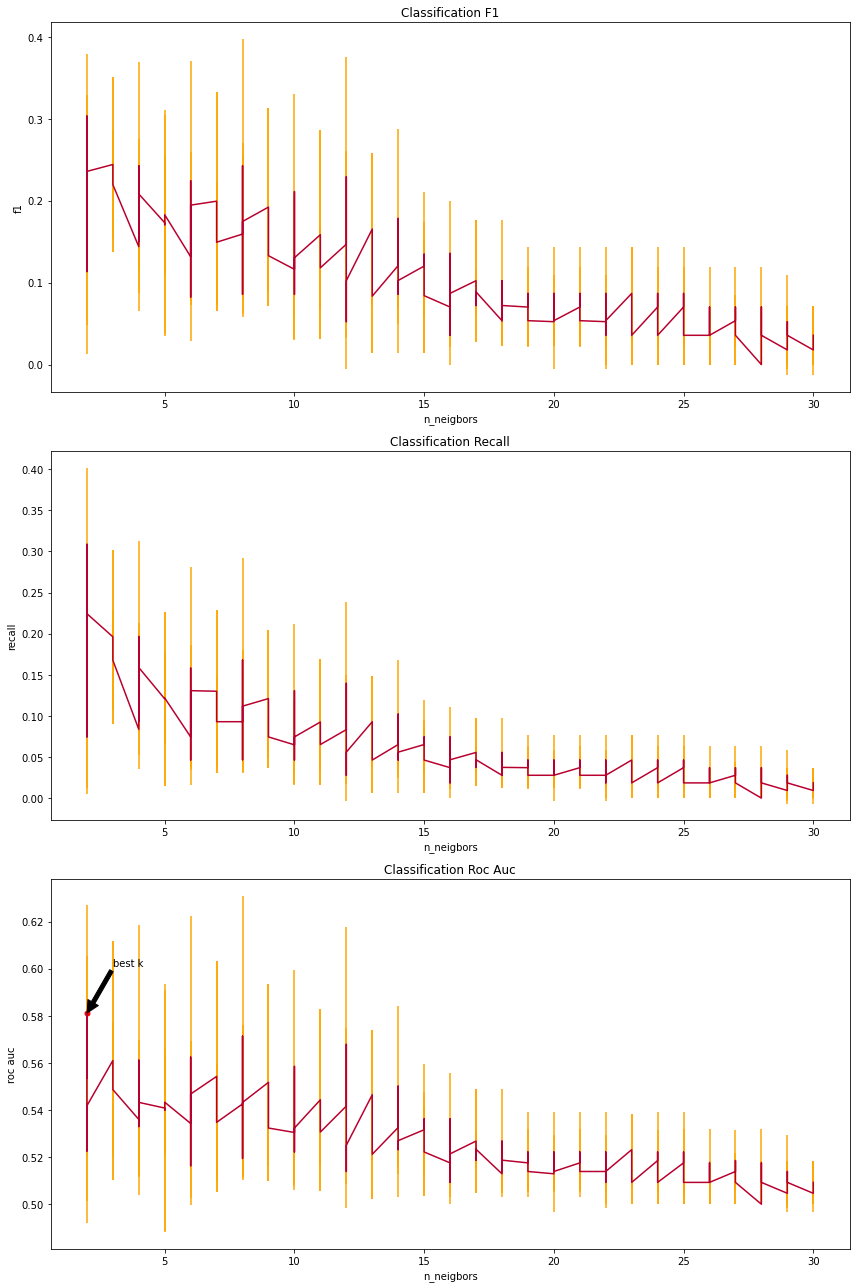



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

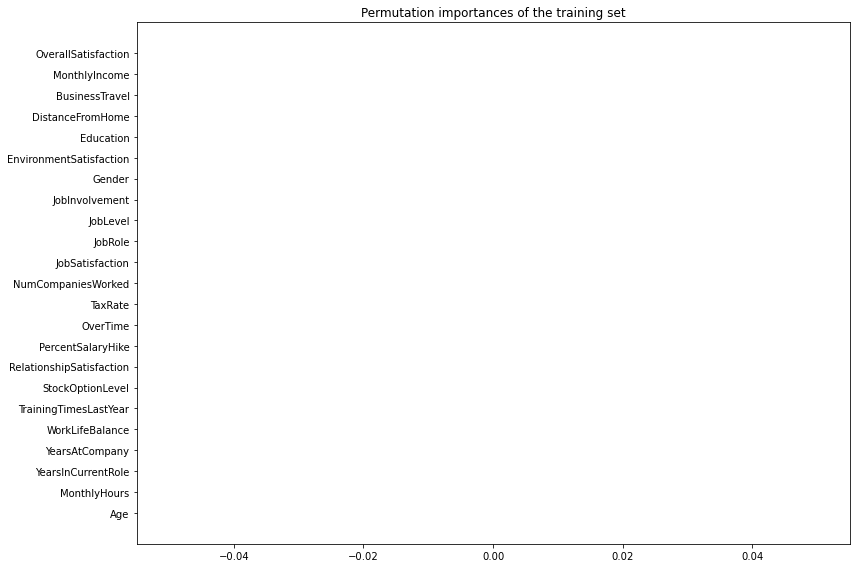



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.042481
JobSatisfaction                                    0.036897
RelationshipSatisfaction                           0.034202
YearsInCurrentRole                                 0.032182
WorkLifeBalance                                    0.024459
YearsAtCompany                                     0.021144
PercentSalaryHike                                  0.019491
OverTime                                           0.017972
JobRole                                            0.016657
NumCompaniesWorked                                 0.015743
OverallSatisfaction                                0.014731
JobInvolvement                                     0.011624
EnvironmentSatisfaction                            0.011009
Age                                                0.004412
MonthlyIncome                                      0.001221
BusinessTravel                              

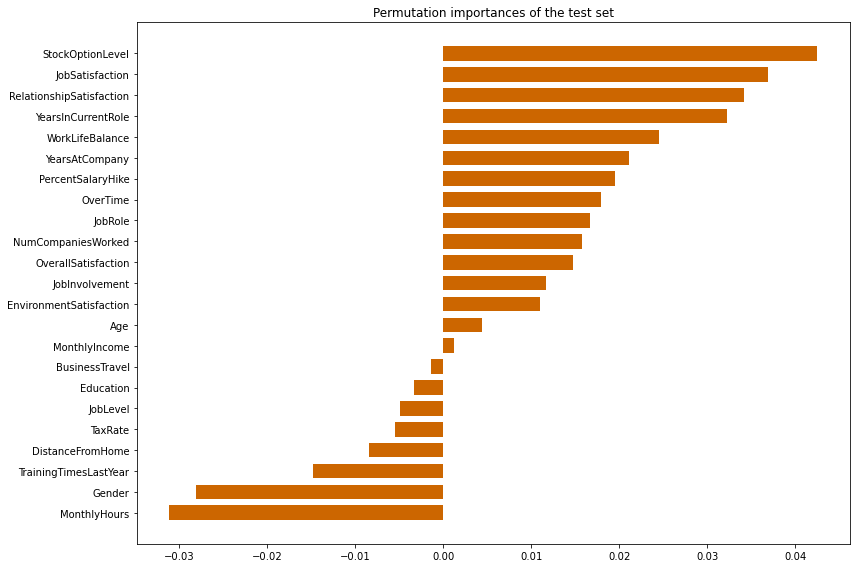



Confusion matrix


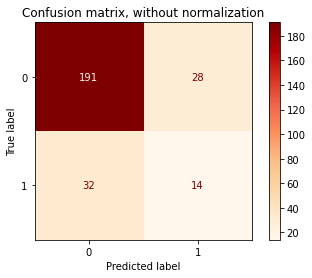

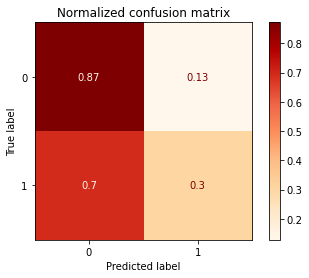


Classification report
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       219
           1       0.33      0.30      0.32        46

    accuracy                           0.77       265
   macro avg       0.59      0.59      0.59       265
weighted avg       0.77      0.77      0.77       265


Metrics

Accuracy 0.7735849056603774
F1-score [0.86425339 0.31818182]
Precision [0.85650224 0.33333333]
Recall [0.87214612 0.30434783]
Roc_auc 0.5882469724042089


Roc curve



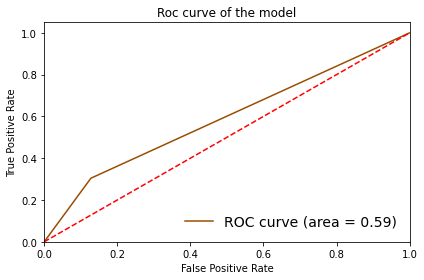


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6176848578583002
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


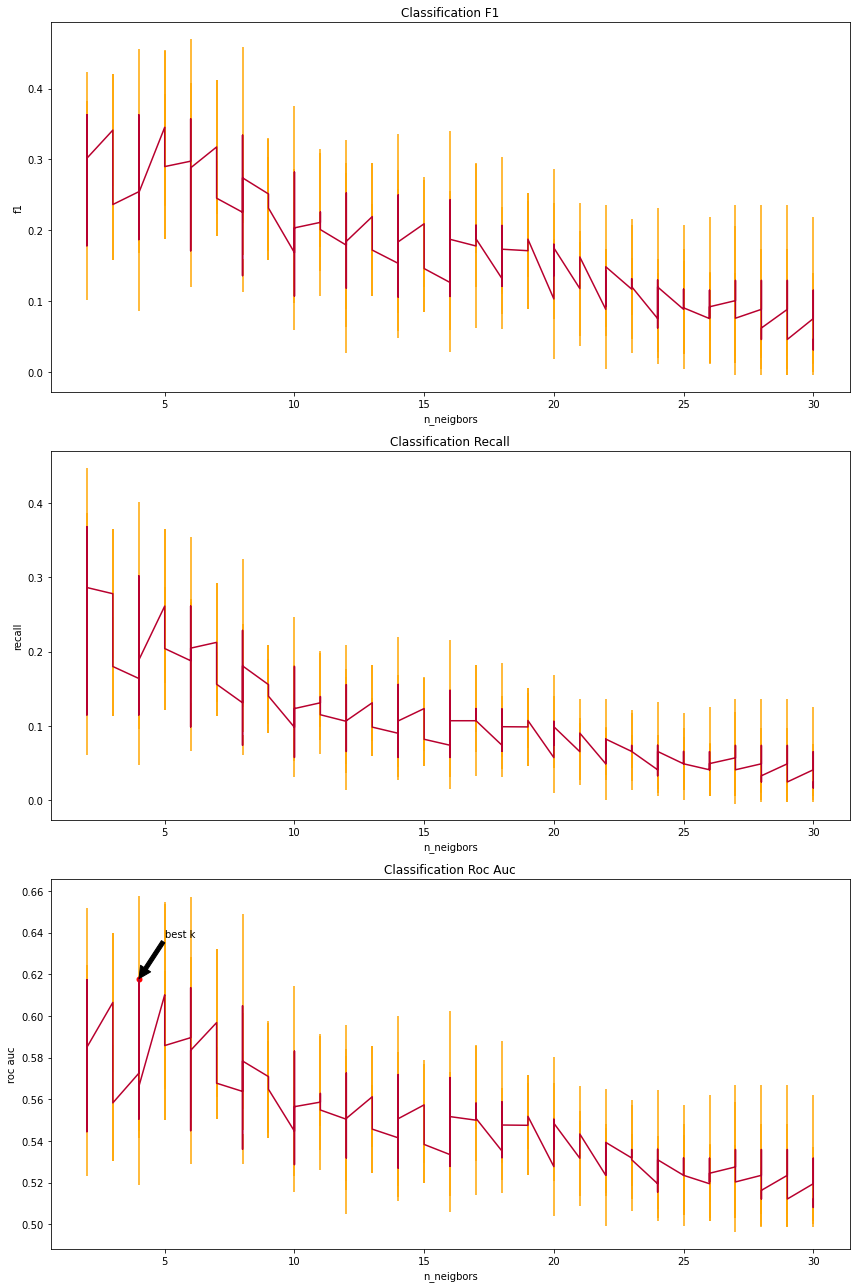



Permutation importances of the training set

StockOptionLevel                                   0.000124
TrainingTimesLastYear                              0.000072
JobRole                                            0.000052
WorkLifeBalance                                    0.000006
JobLevel                                           0.000003
Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.

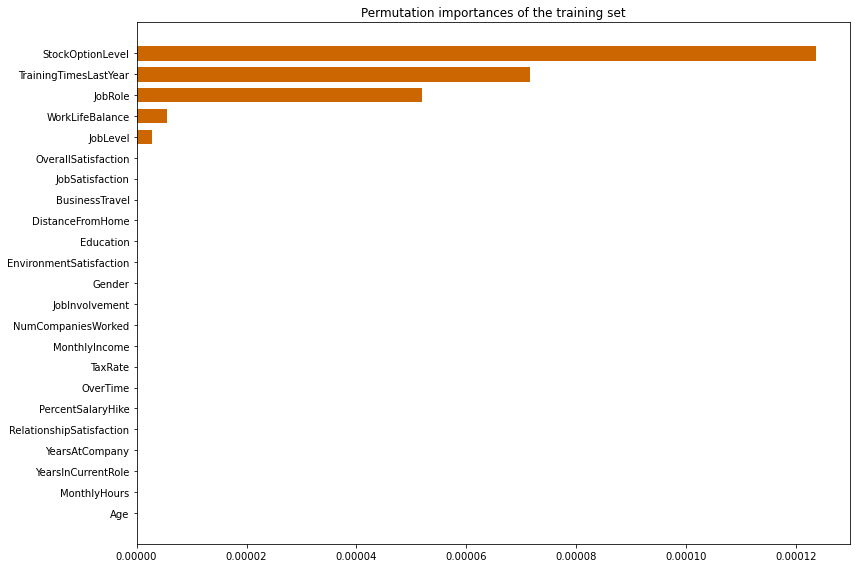



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.033981
JobRole                                            0.030811
WorkLifeBalance                                    0.029485
Education                                          0.021133
NumCompaniesWorked                                 0.018195
DistanceFromHome                                   0.016527
YearsInCurrentRole                                 0.009302
BusinessTravel                                     0.009015
JobInvolvement                                     0.007998
PercentSalaryHike                                  0.006617
RelationshipSatisfaction                           0.005159
JobSatisfaction                                    0.005115
MonthlyIncome                                      0.001757
OverallSatisfaction                                -0.000376
TrainingTimesLastYear                              -0.005490
OverTime                                  

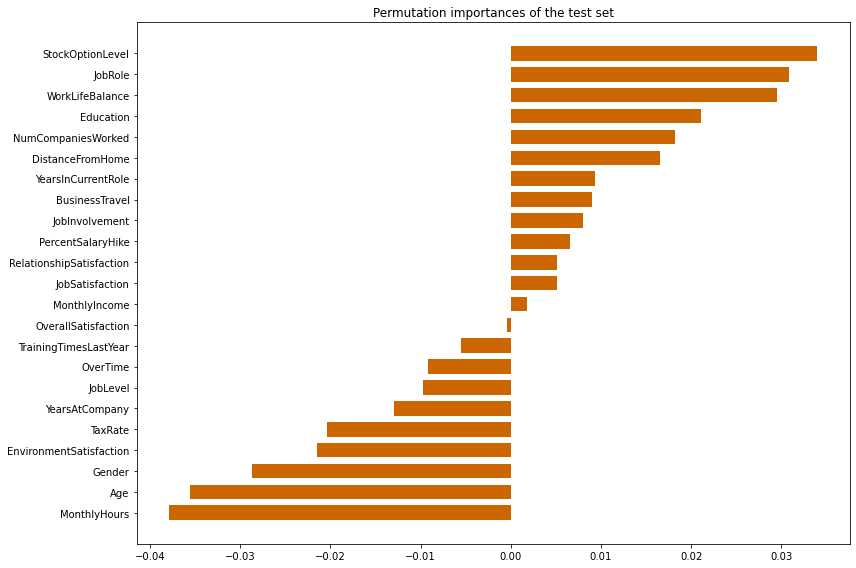



Confusion matrix


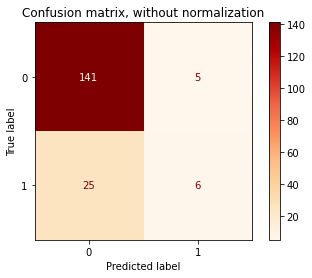

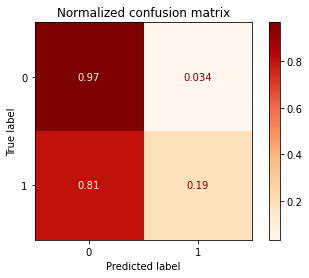


Classification report
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       146
           1       0.55      0.19      0.29        31

    accuracy                           0.83       177
   macro avg       0.70      0.58      0.59       177
weighted avg       0.80      0.83      0.80       177


Metrics

Accuracy 0.8305084745762712
F1-score [0.90384615 0.28571429]
Precision [0.84939759 0.54545455]
Recall [0.96575342 0.19354839]
Roc_auc 0.5796509058771543


Roc curve



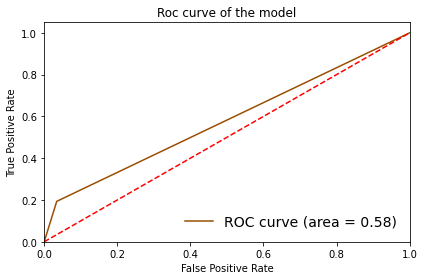


-------------------------------------------------------------------------------------------------------------



In [19]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
robust_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = RobustScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, robust_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = robust_dict

<h4>StandardScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6072519672190593
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


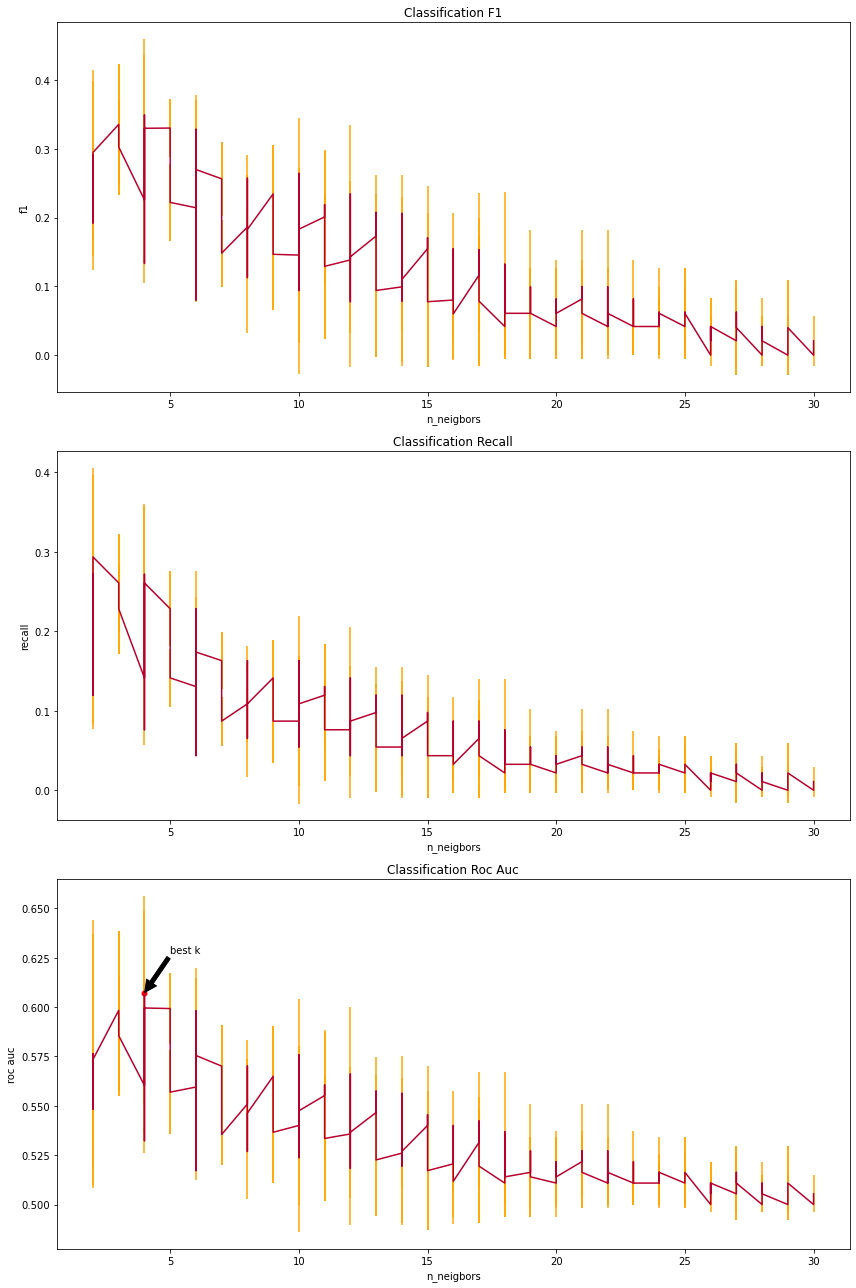



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

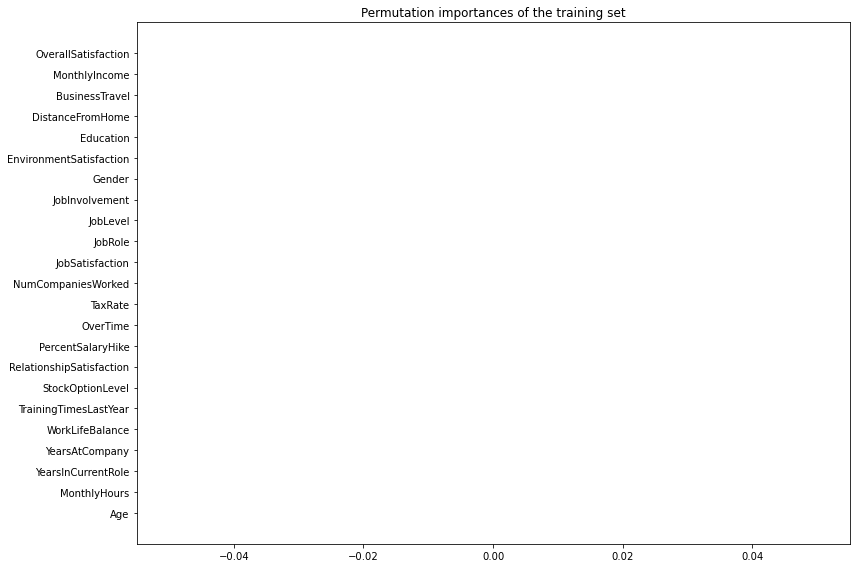



Predictions

Permutation importances of the test set

OverTime                                           0.028957
OverallSatisfaction                                0.019888
StockOptionLevel                                   0.019294
YearsAtCompany                                     0.015652
YearsInCurrentRole                                 0.012589
RelationshipSatisfaction                           0.011089
JobInvolvement                                     0.007064
Age                                                0.005475
JobLevel                                           0.000224
MonthlyIncome                                      -0.001298
EnvironmentSatisfaction                            -0.003005
NumCompaniesWorked                                 -0.003483
JobSatisfaction                                    -0.004068
JobRole                                            -0.005816
Gender                                             -0.009786
DistanceFromHome                      

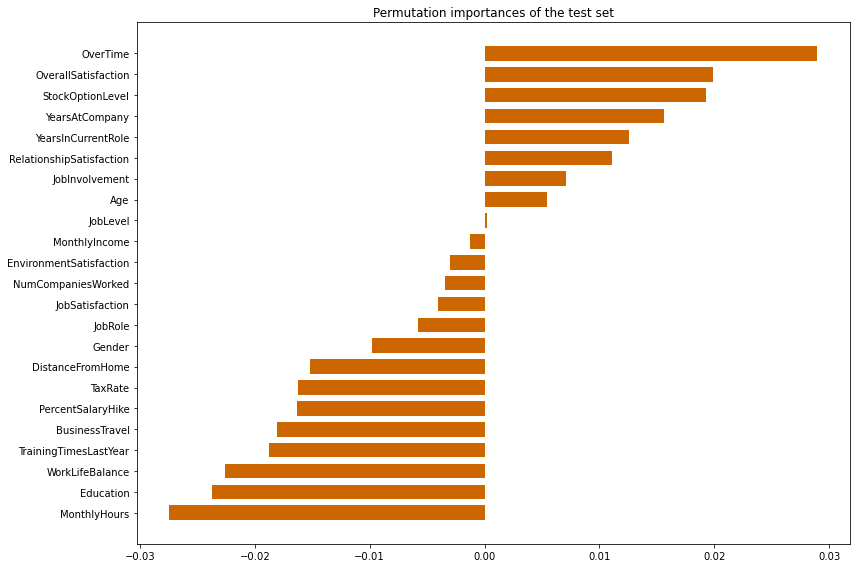



Confusion matrix


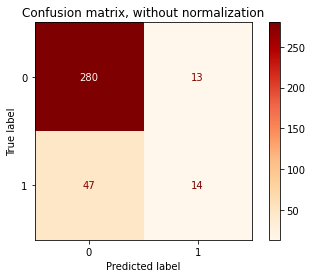

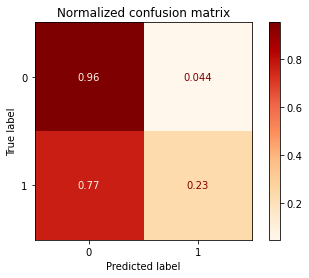


Classification report
              precision    recall  f1-score   support

           0       0.86      0.96      0.90       293
           1       0.52      0.23      0.32        61

    accuracy                           0.83       354
   macro avg       0.69      0.59      0.61       354
weighted avg       0.80      0.83      0.80       354


Metrics

Accuracy 0.8305084745762712
F1-score [0.90322581 0.31818182]
Precision [0.85626911 0.51851852]
Recall [0.9556314 0.2295082]
Roc_auc 0.5925697980193588


Roc curve



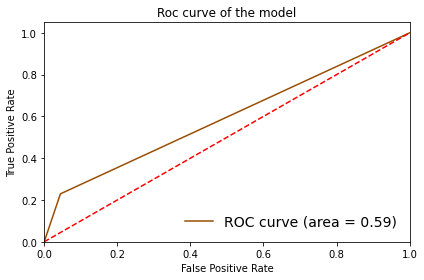


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5952323148358458
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


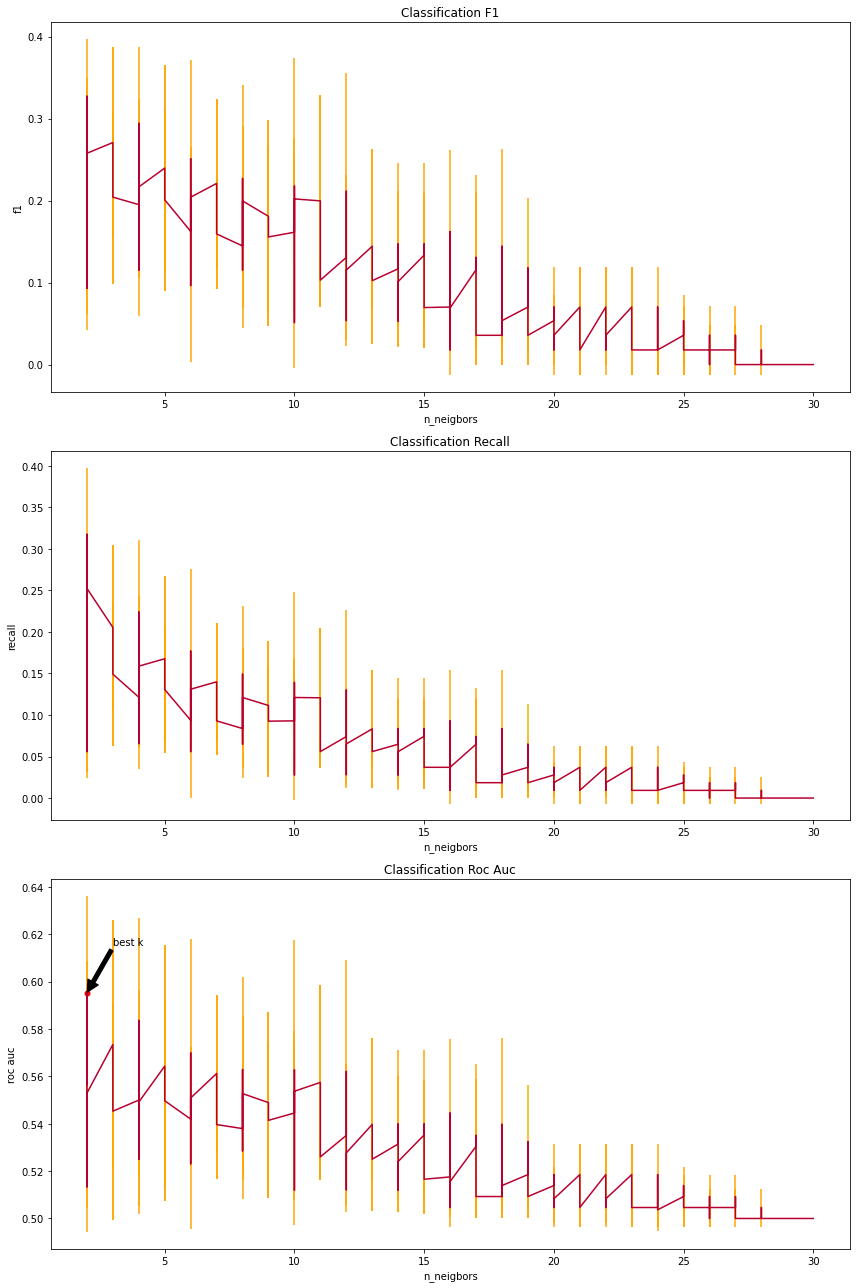



Permutation importances of the training set

Age                                                0.000000
BusinessTravel                                     0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
JobSatisfaction                                    0.000000
MonthlyHours                                       0.000000
MonthlyIncome                                      0.000000
NumCompaniesWorked                                 0.000000
OverTime                                           0.000000
OverallSatisfaction                                0.000000
PercentSalaryHike                                  0.

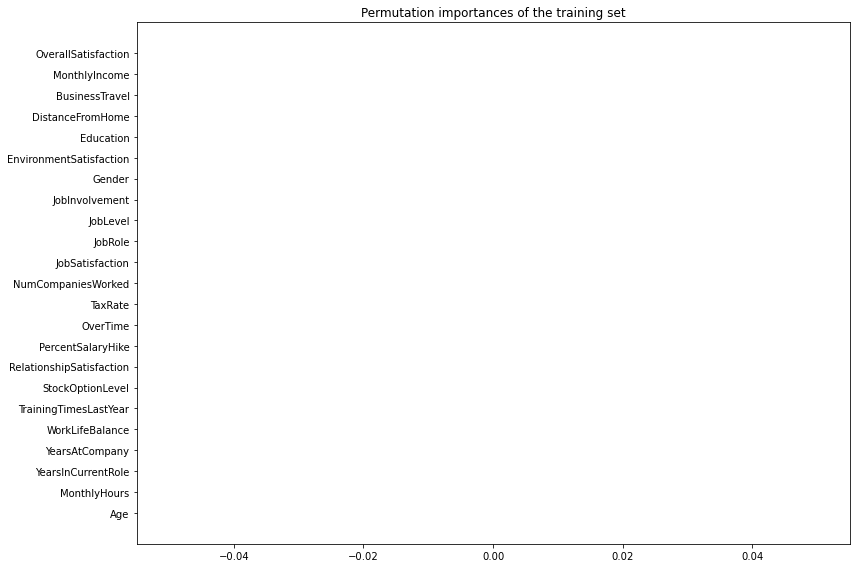



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.045459
WorkLifeBalance                                    0.026618
OverallSatisfaction                                0.021962
NumCompaniesWorked                                 0.017029
Age                                                0.016791
YearsInCurrentRole                                 0.016548
JobInvolvement                                     0.012423
EnvironmentSatisfaction                            0.009391
OverTime                                           0.009068
RelationshipSatisfaction                           0.008279
YearsAtCompany                                     0.007078
JobLevel                                           0.001568
Education                                          0.001464
PercentSalaryHike                                  0.001186
MonthlyIncome                                      0.000243
JobSatisfaction                             

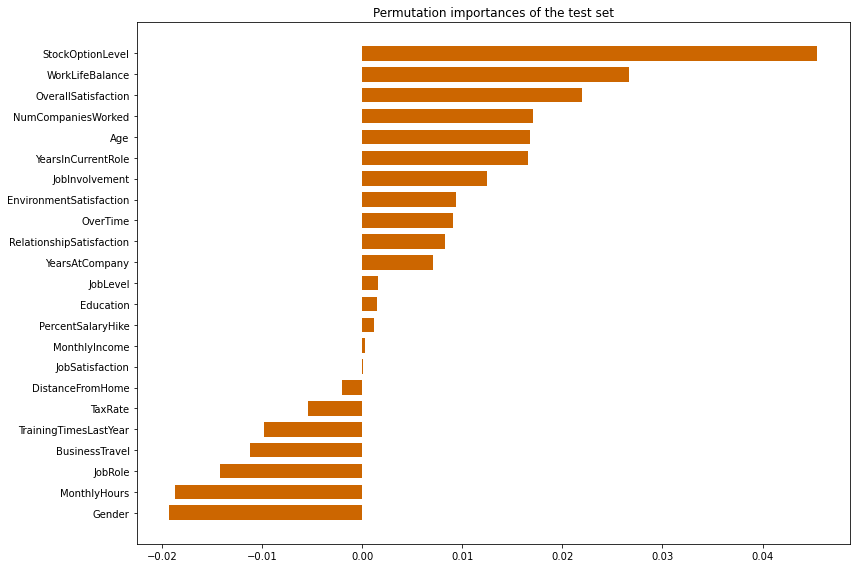



Confusion matrix


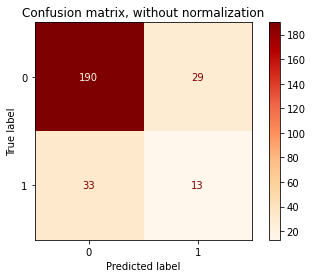

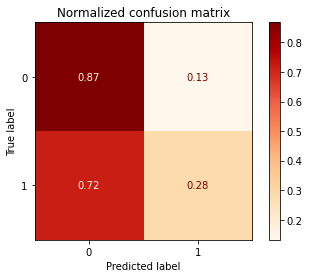


Classification report
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       219
           1       0.31      0.28      0.30        46

    accuracy                           0.77       265
   macro avg       0.58      0.58      0.58       265
weighted avg       0.76      0.77      0.76       265


Metrics

Accuracy 0.7660377358490567
F1-score [0.85972851 0.29545455]
Precision [0.85201794 0.30952381]
Recall [0.86757991 0.2826087 ]
Roc_auc 0.5750943021639865


Roc curve



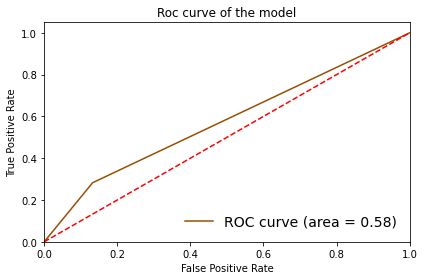


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6343312711739579
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


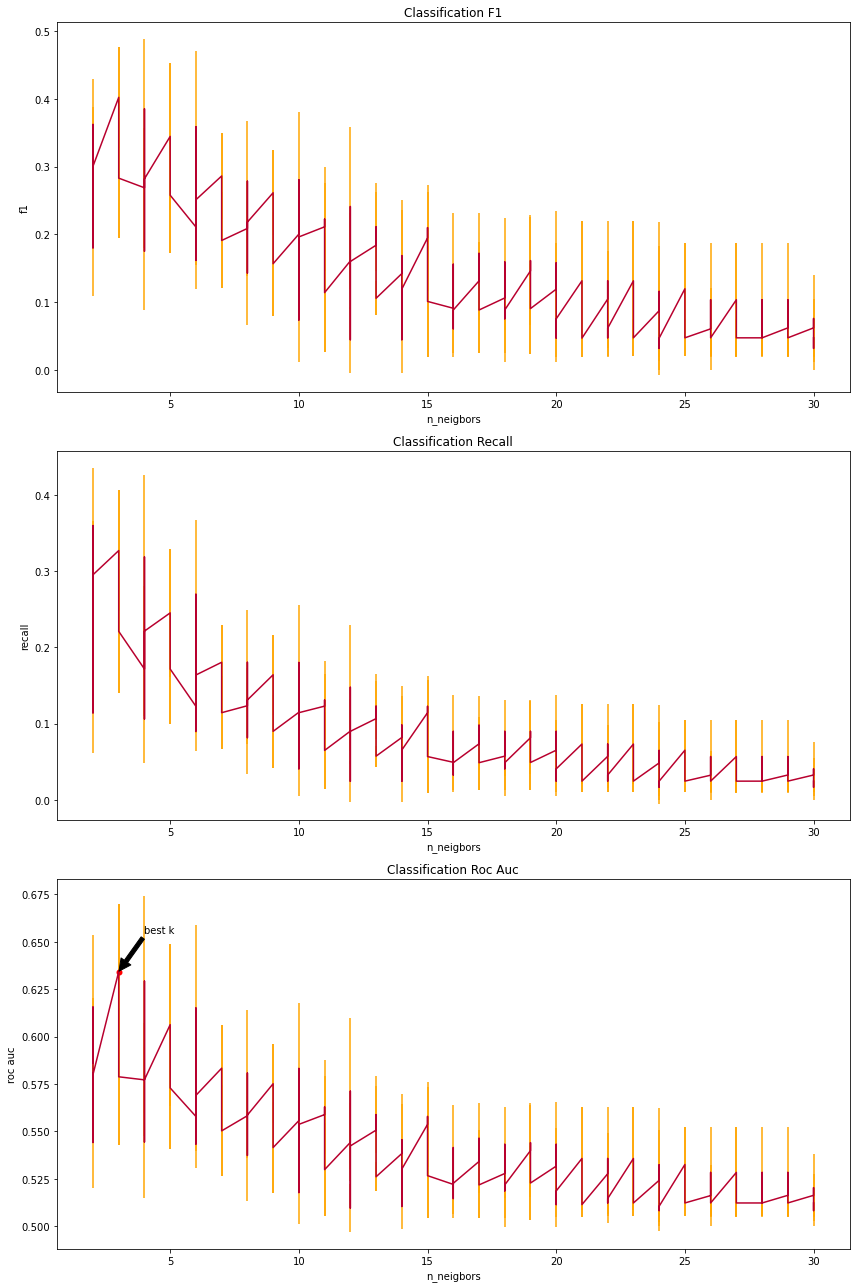



Permutation importances of the training set

OverTime                                           0.019242
StockOptionLevel                                   0.012630
Age                                                0.011993
EnvironmentSatisfaction                            0.011507
YearsAtCompany                                     0.010216
OverallSatisfaction                                0.009978
JobSatisfaction                                    0.009892
MonthlyHours                                       0.008168
JobRole                                            0.007750
YearsInCurrentRole                                 0.007749
TaxRate                                            0.006268
Gender                                             0.005275
DistanceFromHome                                   0.004650
PercentSalaryHike                                  0.004465
Education                                          0.004339
MonthlyIncome                                      0.

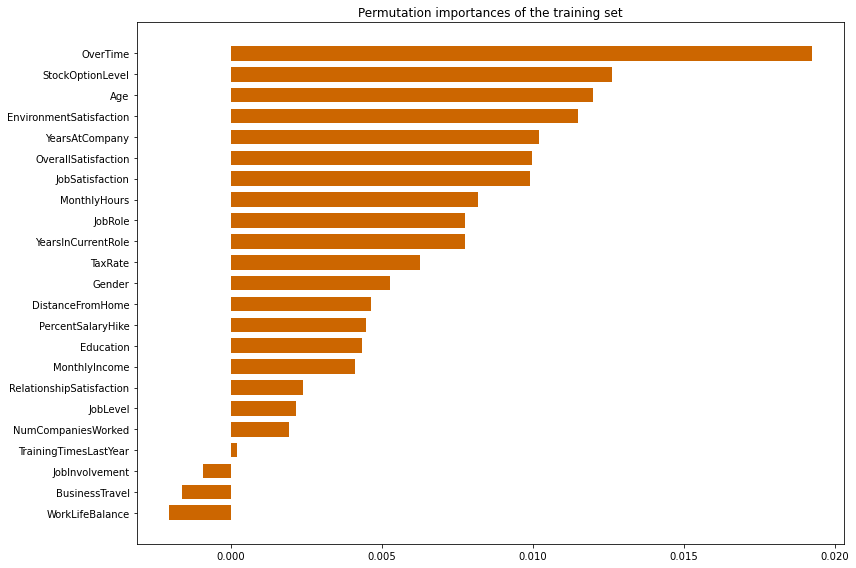



Predictions

Permutation importances of the test set

OverTime                                           0.025287
JobInvolvement                                     0.005844
OverallSatisfaction                                0.003646
DistanceFromHome                                   0.003358
Education                                          -0.001834
YearsInCurrentRole                                 -0.002872
EnvironmentSatisfaction                            -0.010484
BusinessTravel                                     -0.012671
RelationshipSatisfaction                           -0.014251
StockOptionLevel                                   -0.014306
JobSatisfaction                                    -0.016140
MonthlyIncome                                      -0.016494
NumCompaniesWorked                                 -0.021885
TrainingTimesLastYear                              -0.024591
JobLevel                                           -0.025983
Age                              

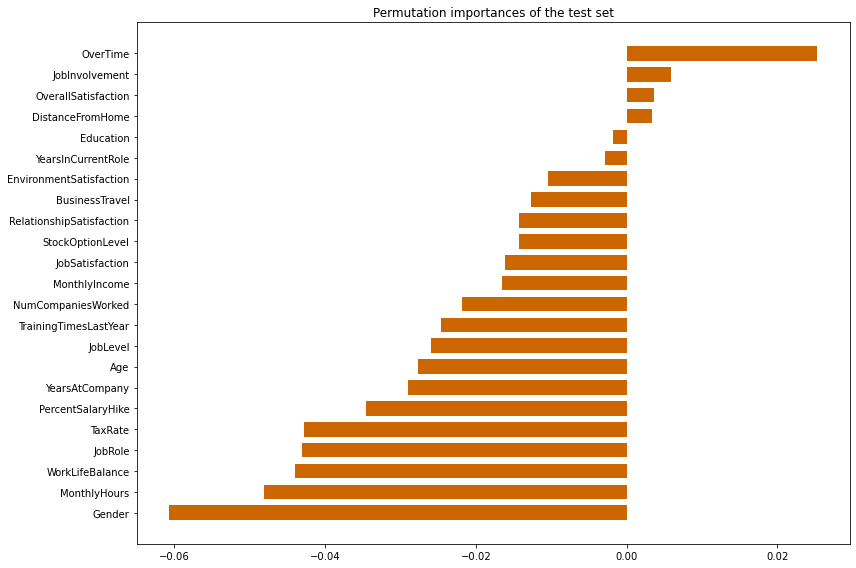



Confusion matrix


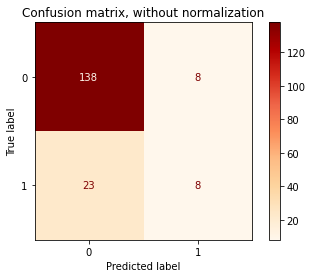

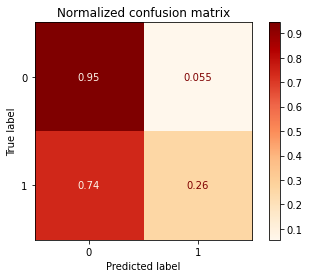


Classification report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       146
           1       0.50      0.26      0.34        31

    accuracy                           0.82       177
   macro avg       0.68      0.60      0.62       177
weighted avg       0.79      0.82      0.80       177


Metrics

Accuracy 0.8248587570621468
F1-score [0.8990228  0.34042553]
Precision [0.85714286 0.5       ]
Recall [0.94520548 0.25806452]
Roc_auc 0.6016349977905435


Roc curve



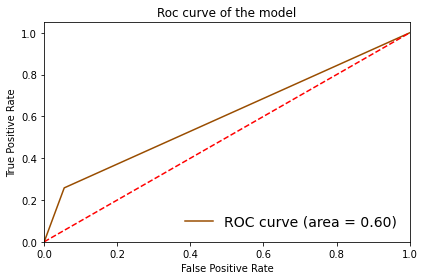


-------------------------------------------------------------------------------------------------------------



In [20]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
standard_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, standard_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = standard_dict

In [21]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.006825938566552901, 1.0],
   'tpr': [0.0, 0.21311475409836064, 1.0],
   'roc': 0.6031444077659038},
  '70-30': {'fpr': [0.0, 0.1461187214611872, 1.0],
   'tpr': [0.0, 0.30434782608695654, 1.0],
   'roc': 0.5791145523128847},
  '80-20': {'fpr': [0.0, 0.11643835616438356, 1.0],
   'tpr': [0.0, 0.25806451612903225, 1.0],
   'roc': 0.5708130799823243}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.030716723549488054, 1.0],
   'tpr': [0.0, 0.22950819672131148, 1.0],
   'roc': 0.5993957365859117},
  '70-30': {'fpr': [0.0, 0.136986301369863, 1.0],
   'tpr': [0.0, 0.2608695652173913, 1.0],
   'roc': 0.5619416319237641},
  '80-20': {'fpr': [0.0, 0.03424657534246575, 1.0],
   'tpr': [0.0, 0.1935483870967742, 1.0],
   'roc': 0.5796509058771543}},
 'RobustScaler': {'60-40': {'fpr': [0.0, 0.06143344709897611, 1.0],
   'tpr': [0.0, 0.22950819672131148, 1.0],
   'roc': 0.5840373748111677},
  '70-30': {'fpr': [0.0, 0.1278538812785388, 1.0],
   'tpr': [0.0, 0.30

In [34]:
temporal_info = {}

In [35]:
model_name = '24f numerical-encoded quantile discretized'

In [36]:
temporal_info[model_name] = scaler_dict['MinMaxScaler']['60-40']
temporal_info

{'24f numerical-encoded quantile discretized': {'fpr': [0.0,
   0.006825938566552901,
   1.0],
  'tpr': [0.0, 0.21311475409836064, 1.0],
  'roc': 0.6031444077659038}}

In [37]:
with open('temporal_info.json', "r+") as json_file: 
    data = json.load(json_file)
    data['qcut']['validation'].update(temporal_info)

    
with open('temporal_info.json','w') as f: 
    json.dump(data, f, indent=4)